# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.

In [1]:
try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: using Google CoLab


# Python Versions
Load the basic libraries and check their versions.

In [2]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")

Tensor Flow Version: 2.3.0
Keras Version: 2.4.0

Python 3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]
Pandas 1.1.2
Scikit-Learn 0.22.2.post1


# Configurations of GPU

Check GPU availability.

In [3]:
print("GPU is", "available" if tf.test.is_gpu_available() \
      else "NOT AVAILABLE")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


## Enabling and Testing GPU

First, you'll need to enable GPUs for the notebook.

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow.

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Upload your Google Drive to Google Colab

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Binary Classification

**Classification** is the process of predicting the class of given data points (supervised learning). 
The concept is that given a paper (abstract + title) we will try to infer the research theme of it. 

We will proceed with **Binary Classification** , namely whether the research theme is *Study* or *Not Study*


# Loading the Binary Data Frame

* First, in jupyter notebook, we ran the parser to our raw data and extract two modified csv files - one for binary classification purposes and one for multi-class classification .
* Then, we upload the files in Google Drive.
* In the code below, we select the path in *read* function to get the **binary_clf.csv** file

In [6]:
import numpy as np
# np.random.seed(42) # for reproducibility

# Import data
import pandas as pd
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/binary_clf.csv")

# First, set the parameters of the notebook
pd.set_option('display.max_columns', 10) # display up to 10 columns
pd.set_option('display.max_rows', 10) # display up to 10 rows

display(df)

,binary_label,text
0,Study,Multivariate Granger causality between CO2 emi...
1,Study,Electricity consumption-GDP nexus in Pakistan:...
2,Study,Ecological total-factor energy efficiency of r...
3,Not Study,Exploration and corrective measures of greenho...
4,Study,Solutions for improving the energy efficiency ...
...,...,...
820,Study,How to quantify the resolution of surface clim...
821,Study,A visual method to identify significant latitu...
822,Study,Effect of production system and farming strate...
823,Study,The effect of future climate scenarios on the ...


In [7]:
# Getting some information about our data (EDA was performed to the 'parser_eda_extract.ipynb')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   binary_label  825 non-null    object
 1   text          825 non-null    object
dtypes: object(2)
memory usage: 13.0+ KB


We have 825 papers of text to work with.

In [8]:
# Getting the input and output data
texts = df['text']
themes = df['binary_label']

We have to convert the categorical text output data into model-understandable numerical data.

**Label Encoder** is part of the SciKit Learn library and it is used to convert categorical data, or text data, into numbers, which our predictive models can better understand.

In [9]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
labels = labelencoder.fit_transform(themes)

In [10]:
# Overview of input data
display(texts)

0      Multivariate Granger causality between CO2 emi...
1      Electricity consumption-GDP nexus in Pakistan:...
2      Ecological total-factor energy efficiency of r...
3      Exploration and corrective measures of greenho...
4      Solutions for improving the energy efficiency ...
                             ...                        
820    How to quantify the resolution of surface clim...
821    A visual method to identify significant latitu...
822    Effect of production system and farming strate...
823    The effect of future climate scenarios on the ...
824    Comparing environmental impacts of beef produc...
Name: text, Length: 825, dtype: object

In [11]:
# Overview of output data
display(labels[:20])

array([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1])

In [12]:
# Sanity check between texts and labels
print(len(texts) == len(labels))

True


Next we want to know the distribution of our labels. The labels take 2 values:
- Study, with binary value of '1'
- Not Study with binary value of '0'

Text(0, 0.5, 'Number of Appearances')

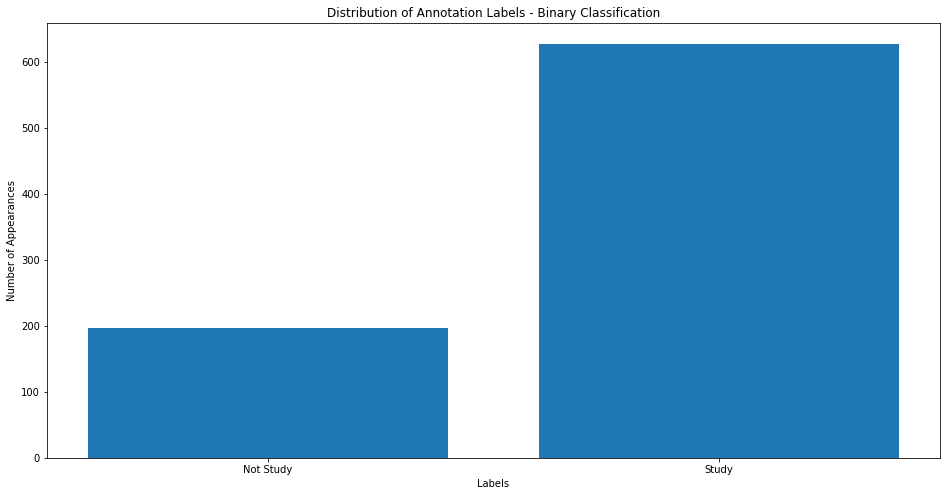

In [13]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

label_count = Counter(labels)

plt.figure(figsize = (16, 8))
plt.bar(label_count.keys(), label_count.values())
plt.xticks([1, 0], ['Study', 'Not Study'])
plt.title("Distribution of Annotation Labels - Binary Classification")
plt.xlabel('Labels')
plt.ylabel('Number of Appearances')

Obviously our dataset is highly unbalanced.
In this case, random sampling is a very bad option for splitting. 

We reach the conclusion that we have to use stratified sampling in order to split the class proportionally between training and test set.

# Preprocessing the dataset

The papers that comprise our dataset, originate from an annotation tool - [link here](https://inventory.clarin.gr/) . 

This means that most of heavy preprocessing such as
- special characters,
- tags, html\code\xml etc. ,

was conducted by the annotation tool during upload. 
Even so we continue with the following preprocess methods, so as to better modify our dataset for the text classification that takes place later on this notebook.

In [14]:
import re

class annotation_preprocess:

    @staticmethod
    def remove_underscores(sentence):
        return re.sub(r'_[A-Za-z0-9]+', ' ', sentence)
    
    @staticmethod
    def remove_multiple_spaces(sentence):
        return re.sub(r' +', ' ', sentence)

    @staticmethod
    def remove_trailing_spaces(sentence):
        return sentence.strip()
    
def annotation_preprocess_row(row):
    row = annotation_preprocess.remove_underscores(row)
    row = annotation_preprocess.remove_multiple_spaces(row)
    row = annotation_preprocess.remove_trailing_spaces(row)
    row = row.lower()
    return row

Static methods, much like class methods, are methods that are bound to a class rather than its object.

They do not require a class instance creation. So, they are not dependent on the state of the object.

The difference between a static method and a class method is:

* Static method knows nothing about the class and just deals with the parameters.
* Class method works with the class since its parameter is always the class itself.

In [15]:
# Apply to the input data and display the results
texts = texts.apply(lambda row: annotation_preprocess_row(row))
display(texts)

0      multivariate granger causality between co2 emi...
1      electricity consumption-gdp nexus in pakistan:...
2      ecological total-factor energy efficiency of r...
3      exploration and corrective measures of greenho...
4      solutions for improving the energy efficiency ...
                             ...                        
820    how to quantify the resolution of surface clim...
821    a visual method to identify significant latitu...
822    effect of production system and farming strate...
823    the effect of future climate scenarios on the ...
824    comparing environmental impacts of beef produc...
Name: text, Length: 825, dtype: object

# Word Embeddings

You cannot feed raw text directly into deep learning models. Text data must be encoded as numbers to be used as input or output for machine learning and deep learning models. Words are called tokens and the process of splitting text into tokens is called **Tokenization**.

A **Word Embedding** is a class of approaches for representing words and documents using a dense vector representation.

It is an improvement over more the traditional bag-of-word model encoding schemes where large sparse vectors were used to represent each word or to score each word within a vector to represent an entire vocabulary. These representations were sparse because the vocabularies were vast and a given word or document would be represented by a large vector comprised mostly of zero values.

Instead, in an embedding, words are represented by dense vectors where a vector represents the projection of the word into a continuous vector space. The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used. The position of a word in the learned vector space is referred to as its embedding.

For this deep learning project we will use 2 methods of learning word embeddings:
- GloVe
- Self-learned as part of a deep learning model

# Tokenizing input text data using Self-trained Word Embeddings

We set some hyperparameters for performing tokenization and preparing the standardized data representation, with explanations below (comments).

In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# maximum number of words from our resulting tokenized data vocabulary,
# which are to be used, truncated after the 5000 most common words in our case. 
max_words = 5000

# Creates a tokenizer, configured to only take into account the 5000 most common words
tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token='<OOV>')
tokenizer

Regarding **oov_token**:
This is the token which will be used for tokens encountered during the tokenizing and encoding of test data sequences

Keras lets us define an **Out Of Vocab** token **(OOV)** - this will replace any unknown words with a token of our choosing. This is better than just throwing away unknown words since it tells our model there was information here.

In [17]:
samples = texts.tolist()

# Build the word index
# Generate tokens by counting frequency
tokenizer.fit_on_texts(samples)

In [18]:
# Turns strings into lists of integer indices, specifically, sequence of numbers
sequences = tokenizer.texts_to_sequences(samples)

# Get max/min text sequence length
seqmax = max([len(x) for x in sequences])
seqmin = min([len(x) for x in sequences])

print("Maximum sequence length is:", seqmax)
print()
print("Minimum sequence length is:", seqmin)

Maximum sequence length is: 811

Minimum sequence length is: 105


Quick explanation on some tokenizer functions:

- **word index:** dictionary that maps each word to a number (dictionary of words and their indices)
- **word_counts:** dictionary of words and the number of times they have appeared in text
- **word_docs:** dictionary of words and the number of documents the appeared in
- **document_count:** total number of documents



At the end you can see that words that are frequently used in discussions about *Sustainable Development Goals* have a lower token number.

In [19]:
print('Word Index')
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(type(word_index))

print()
print('Word Counts')
print(tokenizer.word_counts)

print()
print('Word Docs')
print(tokenizer.word_docs)

print()
print('Document Count')
print(tokenizer.document_count)

print()
print('Some examples')
print('Token for the word "energy": {}'.format(word_index['energy']))
print('Token for the word "source": {}'.format(word_index['source']))
print('Token for the word "game": {}'.format(word_index['game']))
print()
print('We notice that the word "game" is rarely used in discussions concerning SDGs.')

Word Index
Found 13331 unique tokens.
<class 'dict'>

Word Counts
OrderedDict([('multivariate', 30), ('granger', 8), ('causality', 30), ('between', 638), ('co2', 84), ('emissions', 292), ('energy', 795), ('consumption', 201), ('fdi', 8), ('foreign', 29), ('direct', 70), ('investment', 52), ('and', 8985), ('gdp', 60), ('gross', 20), ('domestic', 140), ('product', 27), ('evidence', 207), ('from', 1223), ('a', 3060), ('panel', 38), ('of', 8609), ('bric', 2), ('brazil', 23), ('russian', 2), ('federation', 3), ('india', 75), ('china', 143), ('countries', 449), ('abstract', 403), ('this', 1158), ('paper', 184), ('addresses', 8), ('the', 11012), ('impact', 277), ('both', 267), ('economic', 245), ('growth', 130), ('financial', 51), ('development', 276), ('on', 1472), ('environmental', 318), ('degradation', 23), ('using', 405), ('cointegration', 13), ('technique', 27), ('for', 2376), ('period', 187), ('1980', 13), ('2007', 45), ('except', 21), ('russia', 3), ('1992–2007', 1), ('in', 5712), ('lo

We proceed with Keras **padding**, to make sure that all text sequences we feed into the model have the same length. 

When we are encoding our numeric sequence representations of the text data, our sentences lengths will not be uniform, and so we will need to select a maximum length for sentences and pad unused sentence positions in shorter sentences with a padding character. On the contrary, longer sequences are truncated so that they fit the desired length.

With **pad_sequences** by default this is done by padding 0 in the beginning of each sequence until each sequence has the same length as the longest sequence. By default truncating is also set to **"pre"** , which truncates the beginning part of the sequence

Whether we pre-pad or post-pad sentences is our decision to make, and we have selected **"post"**, meaning that our sentence sequence numeric representations corresponding to word index entries will appear at the left-most positions of our resulting sentence vectors, while the padding characters ('0') will appear after our actual data at the right-most positions of our resulting sentence vectors.

In [20]:
# number of words, cut of text after 200 words
maxlen = 200 
pad_type = 'post'

# Turns the lists of integers into a 2D integer tensor of shape (samples, maxlen)
data = pad_sequences(sequences, padding = pad_type, maxlen=maxlen)

print("Padded training sequences:\n", data)
print()
print('-' * 50)
print()
print("Padded training shape:", data.shape)

Padded training sequences:
 [[   1    1  441 ... 1121    1   45]
 [ 200  145  561 ...    0    0    0]
 [1363   20 3094 ...   13    2 3095]
 ...
 [  87   34  318 ... 1618   36 2337]
 [  17   22  341 ...  223    4  455]
 [1290    3  559 ... 1722  614  493]]

--------------------------------------------------

Padded training shape: (825, 200)


# Splitting/Shuffling Dataset Procedure
Following code performs, data splitting in train-validation datasets,  knowning that we are dealing with an imbalanced dataset.

As mentioned before, we should split the raw dataset in Train - Test in a stratified manner in order to prevent the distribution of the training data to bias our model accordingly to it.

We choose to split the data according to Pareto principle (80/20 is the common occurring ratio).
- Training dataset
- Test/Validation dataset (unseen data)

In [21]:
# The raw input (abstracts)
x = data

# The raw output (binary research themes)
y = labels

In [22]:
# We will use this object to split the raw dataset in Train - Test in a stratified manner.
from sklearn.model_selection import StratifiedShuffleSplit

test_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
test_sss

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)

In [23]:
# splitting in train-val and test
x_train, x_val, y_train, y_val = None, None, None, None

# getting the indexes for each dataset
for train_index, val_index in test_sss.split(x, y):
    
    print("TRAIN:", train_index[:10], "VALID:", val_index[:10])
    
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]

TRAIN: [575 414 152 109 374 235 228 244 330 601] VALID: [787 226 588 572 481 188 676 799 741 775]
TRAIN: [  1 142  21 145 766 696 120 486  25  15] VALID: [198 702 510 260 143 432   9 554 244 178]
TRAIN: [580 279  38 617  23 517 609 563 572 355] VALID: [451 555 143 206 122 283 361  37 752 391]
TRAIN: [588 821 207 527 136 344 818 761 497 181] VALID: [548 163 661  70 656  27   6 419 533  96]
TRAIN: [471 566 749 295 128 519 397 143 308 388] VALID: [ 32 421 334  87 282 418 352 567 228 461]


In [24]:
# Datasets' size & shape after splitting
print("Initial Dataset size:", len(df)) 
print("Training Dataset size:", len(x_train)) 
print("Test/Validation Dataset size:", len(x_val)) 
print()
print('x_train shape: {}'.format(x_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print()
print('x_val shape: {}'.format(x_val.shape))
print('y_val shape: {}'.format(y_val.shape))

Initial Dataset size: 825
Training Dataset size: 660
Test/Validation Dataset size: 165

x_train shape: (660, 200)
y_train shape: (660,)

x_val shape: (165, 200)
y_val shape: (165,)


# Pre-trained GloVe Embeddings

Since you are executing below UNIX commands during Colab session, the files will be available only for the running session. In case you want to re-run any steps, do not execute those commands again (better to comment them out).

In [25]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-10-20 06:04:15--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-10-20 06:04:15--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-10-20 06:04:16--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [26]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [27]:
from tqdm import tqdm

def load_glove_embeddings(dim: int = 100) -> dict:
    """
    Function that loads glove embeddings. 

    :param dim: The embeddings size (dimensions)
    :return:
    """
    print('Loading word vectors')

    embed_index = dict()  # We create a dictionary of word -> embedding

    fname = 'glove.6B.{}d.txt'.format(dim)

    f = open(fname)  # Open file

    # In the dataset, each line represents a new word embedding
    # The line starts with the word and the embedding values follow
    for line in tqdm(f, desc='Loading Embeddings', unit='word'):
        values = line.split()
        # The first value is the word, the rest are the values of the embedding
        word = values[0]
        # Load embedding
        embedding = np.asarray(values[1:], dtype='float32')

        # Add embedding to our embedding dictionary
        embed_index[word] = embedding
    f.close()

    print('Found %s word vectors.' % len(embed_index))

    return embed_index

In [28]:
pre_embedding_dim = 100  # We now use larger embeddings

embeddings_index = load_glove_embeddings(dim=pre_embedding_dim)

Loading Embeddings: 6427word [00:00, 32383.36word/s]

Loading word vectors


Loading Embeddings: 400000word [00:13, 30528.62word/s]

Found 400000 word vectors.


In [29]:
embeddings_index['energy']

array([ 0.014314 ,  0.68838  ,  1.0354   , -0.22272  ,  0.7122   ,
       -1.8591   , -0.54074  ,  0.3788   , -0.4473   ,  0.39239  ,
        0.015253 , -0.91126  , -0.75051  , -0.20166  , -0.38735  ,
       -0.76363  , -0.30962  ,  0.46411  ,  0.086319 , -0.48519  ,
       -0.23435  , -0.47433  , -0.0079533, -0.11603  , -0.51613  ,
        0.903    , -0.089598 ,  0.57729  , -0.22603  ,  0.72144  ,
       -0.25002  ,  0.1062   , -0.94918  , -0.084096 , -0.62692  ,
       -0.17111  ,  0.1704   ,  0.38448  ,  0.039208 , -0.12554  ,
        0.17141  , -1.1132   , -0.5683   , -0.093456 , -0.028492 ,
       -0.01072  , -0.58381  ,  0.46759  , -0.15049  , -0.59781  ,
        0.18358  , -0.11986  ,  0.14094  ,  1.0061   ,  0.35668  ,
       -2.1176   , -0.11615  ,  0.14937  ,  1.6014   ,  0.3073   ,
        0.68025  , -0.69607  , -0.69121  , -0.23822  ,  1.0161   ,
        0.46592  ,  0.5549   , -0.12957  ,  1.3661   , -0.39927  ,
        0.70148  , -0.023808 ,  0.42136  , -0.4654   ,  0.1101

In [30]:
embeddings_index['energy'].shape

(100,)

Not all words that are in our **annotation** vocabulary might be in the GloVe embedding though. For missing words it is wise to use random embeddings with the same mean and standard deviation as the GloVe embeddings.

In [31]:
def create_embeddings_matrix(emb_index: dict,
                             tokenizer: Tokenizer,
                             emb_dim: int = 100) -> np.ndarray:
    """

    :param emb_index: Embeddings Index
    :param tokenizer: Keras fitted tokenizer.
    :param emb_dim: Embeddings dimension.
    :return: A matrix of shape (nb_words, emb_dim) containing the globe embeddings.
    """
    assert emb_dim in [50, 100, 200, 300]

    # Create a matrix of all embeddings
    # (stacking=concatenating all the vectors)
    all_embs = np.stack(emb_index.values())  # .values() gets the all the arrays from the keys

    # Calculate mean
    emb_mean = all_embs.mean()
    # Calculate standard deviation
    emb_std = all_embs.std()

    print("Embeddings AVG: {} | STD: {}".format(emb_mean, emb_std))

    # We can now create an embedding matrix holding all word vectors.

    word_index = tokenizer.word_index

    # How many words are there actually. Because we may have requested X most common tokens
    # and the total tokens are X/2
    nb_words = min(max_words, len(word_index))

    # Create a random matrix with the same mean and std as the embeddings

    embedding_matrix = np.random.normal(emb_mean,  # mean
                                        emb_std,  # std
                                        (nb_words, emb_dim)) # shape of the matrix

    # The vectors need to be in the same position as their index.
    # Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on
    
    counter = 0
    
    # Loop over all words in the word index
    for word, i in word_index.items():  # .items() return a tuple with (word, word_index)

        # If we are above the amount of words we want to use we do nothing
        if i >= max_words:
            continue

        # Get the embedding vector for the word
        embedding_vector = emb_index.get(word)

        # If there is an embedding vector, put it in the embedding matrix
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            counter += 1
    
    print(f'Found {counter} pre-trained embeddings out of {nb_words}')
    
    return embedding_matrix

In [32]:
embedding_matrix = create_embeddings_matrix(
    emb_index=embeddings_index, 
    tokenizer=tokenizer, 
    emb_dim=pre_embedding_dim
    )

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Embeddings AVG: 0.004451991990208626 | STD: 0.4081574082374573
Found 4854 pre-trained embeddings out of 5000


This embedding matrix is used as weights for the embedding layer. This way, the embedding layer uses the pre-trained GloVe weights instead of random ones.

We can also set the embedding layer to NOT trainable. This means, Keras won't change the weights of the embeddings while training which makes sense since our embeddings are already trained.

# Multi-Layer Perceptron Neural Network
Multi-Layer Perceptrons, or MLPs for short, are the classical type of neural network. 

They are comprised of one or more layers of neurons. Data is fed to the input layer, there may be one or more hidden layers providing levels of abstraction, and predictions are made on the output layer, also called the visible layer.

# Convolutional Neural Network
Convolutional Neural Networks, or CNNs, were designed to map image data to an output variable. They have revolutionized image classification and computer vision by being able to extract features from images and using them in neural networks.

The benefit of using CNNs is their ability to develop an internal representation of a two-dimensional image. This allows the model to learn position and scale in variant structures in the data, which is important when working with images.

More generally, CNNs work well with data that has a spatial relationship. The CNN input is traditionally two-dimensional, a field or matrix, but can also be changed to be one-dimensional, allowing it to develop an internal representation of a one-dimensional sequence.

This allows the CNN to be used more generally on other types of data that has a spatial relationship. For example, there is an order relationship between words in a document of text. 

## Regarding CNNs' Layers
A CNN has hidden layers which are called convolutional layers. When you think of images, a computer has to deal with a two dimensional matrix of numbers and therefore you need some way to detect features in this matrix. These convolutional layers are able to detect edges, corners and other kinds of textures which makes them such a special tool. The convolutional layer consists of multiple filters which are slid across the image and are able to detect specific features.

When you are working with sequential data, like text, you work with one dimensional convolutions, but the idea and the application stays the same. You still want to pick up on patterns in the sequence which become more complex with each added convolutional layer.

# Import Libraries

In [33]:
from keras import backend as K

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.utils import plot_model
from pprint import pprint

from typing import List, Tuple
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Variations - Hyperparameter Tuning

## Keras Embedding Layer
Keras offers an Embedding layer that can be used for neural networks on text data with either approaches:
- Learning an Embedding
- Using Pre-Trained GloVe Embedding

It requires that the input data be integer encoded, so that each word is represented by a unique integer. This data preparation step was performed using the Tokenizer API also provided with Keras. 
The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset.

The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments:
- **input_dim:** This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.
- **output_dim:** This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger.
- **input_length:** This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.

## Dropout Regularization
Dropout Regularization is a computationally cheap way to regularize a deep neural network.
Dropout works by probabilistically removing, or “dropping out,” inputs to a layer, which may be input variables in the data sample or activations from a previous layer. It has the effect of simulating a large number of networks with very different network structure and, in turn, making nodes in the network generally more robust to the inputs. 

Dropout value needs finetuning because a probability too low has minimal effect and a value too high results in under-learning by the network. Dropout can be used on visible as well as hidden units. Application of dropout at each layer of the network has shown good results.

## Batch Normalization
Batch Normalization is just another layer, so you can use it as such to create your desired network architecture. It is a technique designed to automatically standardize the inputs to a layer in a deep learning neural network.

The general use case is to use BN between the linear and non-linear layers in your network, because it normalizes the input to your activation function, so that you're centered in the linear section of the activation function (such as Sigmoid) . It applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 

Once implemented, batch normalization has the effect of dramatically accelerating the training process of a neural network, and in some cases improves the performance of the model via a modest regularization effect.

## Activation Functions
Activation functions, in layman's terms, are a choice that you must make for each layer:
- **relu:** Very popular neural network activation function. Used for hidden layers, cannot output negative values. No trainable parameters
- **sigmoid:** Classic neural network activation. Often used on output layer of a binary classifier.

## Loss functions
### BinaryCrossentropy
Computes the cross-entropy loss between true labels and predicted labels. 
Use this cross-entropy loss when there are only two label classes (assumed to be 0 and 1). For each example, there should be a single floating-point value per prediction.

## Keras Callbacks

### Model Checkpoint
Save the current weights of the model at different points
during training.

### Early Stopping
Interrupt training once a target metric being monitored has stopped improving for a fixed number of epochs. For instance, this callback allows you to interrupt training as soon as you start overfitting, thus avoiding having to retrain your model for a smaller number of epochs.

### ReduceLROnPlateau
Reduce learning rate when a metric has stopped improving.

## Configuration of the Model
The model that we will create is a sequential model meaning that each layer that we add per line will use as input the output of the former layer added to the model. We have to specify:

- **embedding_dim:** how large we want the word vectors to be. A 50 dimensional vector is able to capture good embeddings even for quite large vocabularies
- **max_words:** for how many words we want embeddings
- **maxlen:** how long our sequences are

### Training Parameter
Regarding **batch size** and **epochs**, both are integer values:

- The batch size is a hyperparameter that controls the number of training samples to work through before the model’s internal parameters are updated.
- The number of epochs is a hyperparameter that controls the number of complete passes through the training dataset

### Neurons and Layers
Usually it is not a good idea to use less neurons on intermediate layers. Small layers may act as information bottlenecks, permanently dropping relevant information.

In [34]:
def add_space():
  print() 
  print("-" * 50) 
  print()

In [35]:
n_classes = len(df['binary_label'].value_counts())
print("Number of Classes: ", n_classes)
add_space()
print("For how many words we want embeddings: ", max_words)
add_space()
print("How long our sequences are: ", maxlen)
add_space()

# Smaller Embeddings than Pre-trained Models
self_embedding_dim  = 50
print("Size of word vectors: ", self_embedding_dim)

Number of Classes:  2

--------------------------------------------------

For how many words we want embeddings:  5000

--------------------------------------------------

How long our sequences are:  200

--------------------------------------------------

Size of word vectors:  50


In [36]:
def plot_keras_history(history):
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

In [37]:
def plot_binary_class_row_auc(y_true,
                              clf_names: list,
                              clfs_preds: list):
    """

    :param y_true: The true labels in one hot encoding
    :param clf_names: The names of the classifiers in order to plot
    :param clfs_preds: A list of numpy arrays, that contain predictions from various classifiers
    :return:
    """
    assert len(clf_names) == len(clfs_preds)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')

    for clf_name, preds in zip(clf_names, clfs_preds):
        fpr, tpr, thresholds = roc_curve(y_true,
                                         preds)

        # AUC value can also be calculated like this.

        auc_score = auc(fpr, tpr)

        plt.plot(fpr,
                 tpr,
                 label='{} (area = {:.3f})'.format(clf_name, auc_score))

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

**Note:** Regarding the following 3 functions - _recall, precision, f1_ - and the building blocks of our Models, read the _Methodology_ chapter from the Report, then proceed. This _"break"_, acts as the catalyst as to why we chose the following approaches when building our Models **(the big picture)**

In [38]:
def recall(y_true, y_pred):
    
    """
    Recall metric.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):
    
    """
    Precision metric.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    
    """Calculate the F1 score."""
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))

In [39]:
def predict_new_comment(text: str,
                        tokenizer: Tokenizer,
                        seq_max_length: int,
                        model: Sequential):
    """

    :param text: str. 
    :param tokenizer: The fitted keras tokenizer
    :param seq_max_length: Max tokens to user from sequence
    :param model: Trained keras sequential model
    :return: int. 
    """
    seq = tokenizer.texts_to_sequences([text])
    seq = pad_sequences(seq, padding = 'post', maxlen=seq_max_length)

    prediction = model.predict(seq)
    prob = 100 * prediction[0][0]
    print('Study probability: {} %'.format(round(prob, 3)))
    return int(prob > 50.0)

# MLP - No Embedding Layer

## Model 1
- Hidden Layers: 2
- Neurons: 8, 16
- Dropout: 0.2
- Optimizer: Nadam


--------------------------------------------------

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1608      
_________________________________________________________________
activation (Activation)      (None, 8)                 0         
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
den

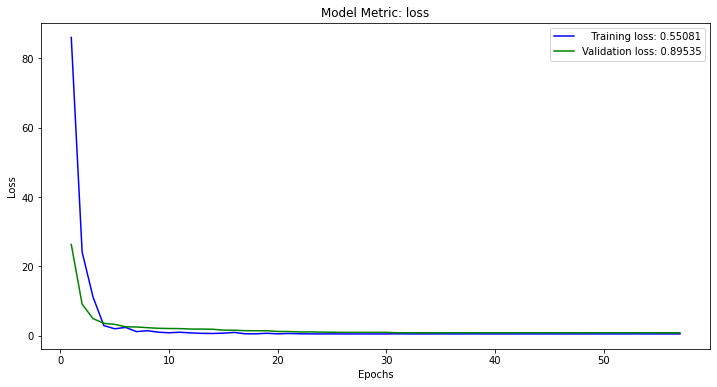

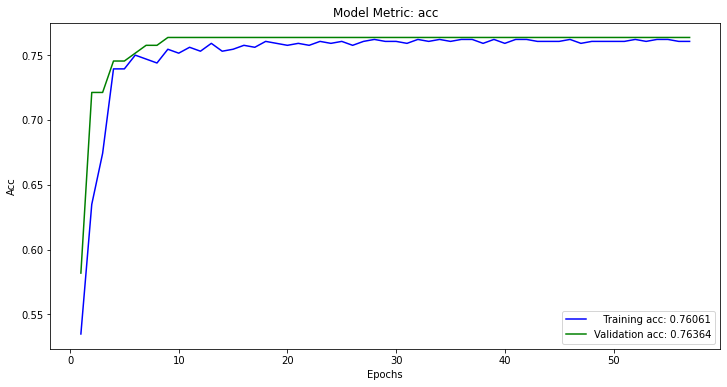

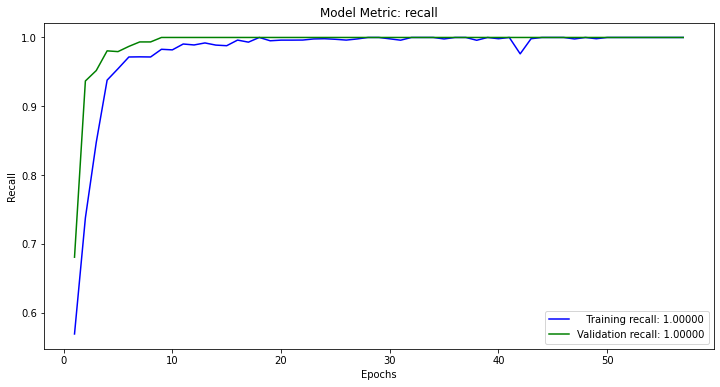

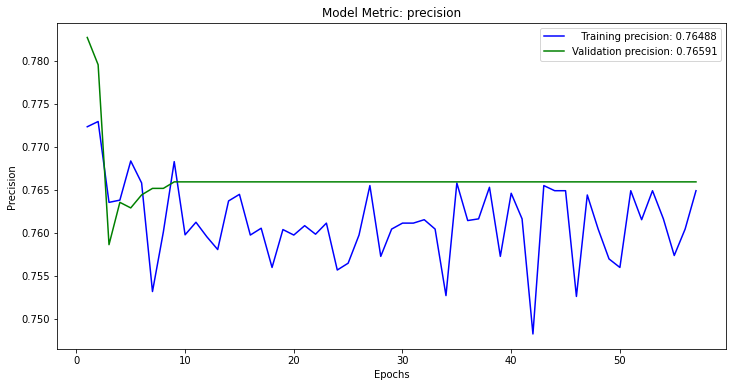

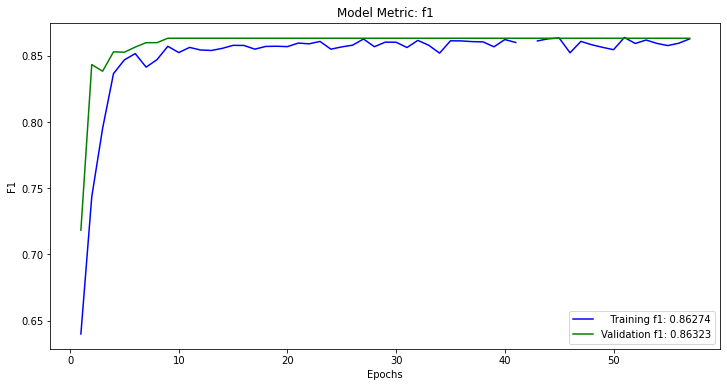

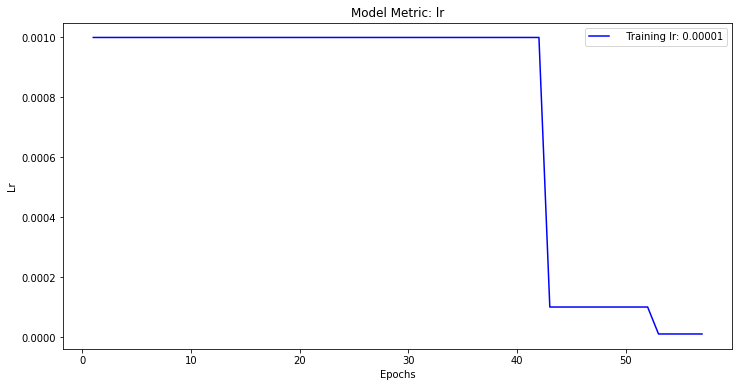

6/6 [==============================] - 0s 3ms/step - loss: 0.8913 - acc: 0.7636 - recall: 1.0000 - precision: 0.7688 - f1: 0.8674

--------------------------------------------------


Binary Crossentropy for model: 89.129 %

Accuracy for model: 76.364 %

Recall for model: 100.000 %

Precision for model: 76.875 %

F1 for model: 86.738 %

--------------------------------------------------


--------------------------------------------------

Fitting Random Forests CLF

--------------------------------------------------

Fitting Logistic Regression CLF

--------------------------------------------------



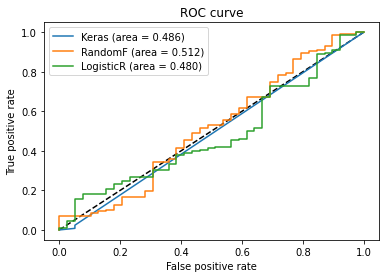


--------------------------------------------------

Study probability: 75.415 %


1

In [41]:
# Define Keras Callbacks

keras_callbacks = [ 
             EarlyStopping( 
                 monitor = 'val_loss', 
                 min_delta = 0.0001,
                 mode='min',
                 patience = 25, 
                 restore_best_weights = True,
                 verbose = 1, 
                 ), 

             ModelCheckpoint( 
                 filepath='noembed_mlp_baseadam_h5', 
                 monitor='val_loss', 
                 mode='min',
                 save_best_only = True, 
                 save_weights_only = False,
                 verbose = 1 
                 ), 

             ReduceLROnPlateau( 
                 monitor = 'val_loss', 
                 factor = 0.1, 
                 patience = 10, 
                 verbose = 1 
                 ) 
             ]

# Define The Neural Network Model

# Define an empty sequential structure
noembed_mlp_baseadam_model = Sequential()

# Input layer
noembed_mlp_baseadam_model.add(Dense(8, input_dim=x_train.shape[1]))
noembed_mlp_baseadam_model.add(Activation('relu'))
noembed_mlp_baseadam_model.add(Dropout(0.2))

# Hidden layer    
noembed_mlp_baseadam_model.add(Dense(16))
noembed_mlp_baseadam_model.add(Activation('relu'))
noembed_mlp_baseadam_model.add(Dropout(0.2))

# Hidden layer    
noembed_mlp_baseadam_model.add(Dense(16))
noembed_mlp_baseadam_model.add(Activation('relu'))
noembed_mlp_baseadam_model.add(Dropout(0.2))

# Output Layer
noembed_mlp_baseadam_model.add(Dense(1,  activation = 'sigmoid'))

add_space()
noembed_mlp_baseadam_model.summary()

add_space()
plot_model(
    noembed_mlp_baseadam_model, 
    to_file='noembed_mlp_baseadam_model_plot.png', 
    show_shapes=True, 
    show_layer_names=True
    )

add_space()
print('Compiling Model..')

# Compile model
noembed_mlp_baseadam_model.compile(
    loss='binary_crossentropy', 
    optimizer='nadam', 
    metrics=['acc', recall, precision, f1]
    )

add_space()
print('Fitting Model..')
# Model Fit
history_noembed_mlp_baseadam_model = noembed_mlp_baseadam_model.fit(
    x_train, y_train, epochs=250, batch_size=16, 
    validation_data=(x_val, y_val), verbose = 1, 
    callbacks = keras_callbacks, shuffle = True 
    )

add_space()
pprint(history_noembed_mlp_baseadam_model.history)

add_space()
plot_keras_history(history_noembed_mlp_baseadam_model)

# Model Evaluation
score_noembed_mlp_baseadam_model = noembed_mlp_baseadam_model.evaluate( 
    x_val, y_val, 
    batch_size=32, 
    verbose=1
    )

add_space()
print('\nBinary Crossentropy for model: {:.3f} %'.format(score_noembed_mlp_baseadam_model[0]*100))
print('\nAccuracy for model: {:.3f} %'.format(score_noembed_mlp_baseadam_model[1]*100))
print('\nRecall for model: {:.3f} %'.format(score_noembed_mlp_baseadam_model[2]*100))
print('\nPrecision for model: {:.3f} %'.format(score_noembed_mlp_baseadam_model[3]*100))
print('\nF1 for model: {:.3f} %'.format(score_noembed_mlp_baseadam_model[4]*100))


add_space()
# Model Prediction
y_pred_keras = noembed_mlp_baseadam_model.predict(x_val).ravel()
add_space()

print('Fitting Random Forests CLF')
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=50)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict_proba(x_val)[:, 1]

add_space()
print('Fitting Logistic Regression CLF')
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred_lr = lr.predict_proba(x_val)[:, 1]

add_space()
plot_binary_class_row_auc(
    y_true=y_val, 
    clf_names=['Keras', 'RandomF', 'LogisticR'], 
    clfs_preds=[y_pred_keras, y_pred_rf, y_pred_lr])



noembed_mlp_baseadam_model_text = 'Multivariate Granger causality between CO2 emissions, energy consumption, FDI (foreign direct investment) and GDP (gross domestic product): Evidence from a panel of BRIC (Brazil, Russian Federation, India, and China) countries' \
'This paper addresses the impact of both economic growth and financial development on environmental degradation using a panel cointegration technique for the period between 1980 and 2007, except for Russia (1992â€“2007).' \
'In long-run equilibrium, CO2 emissions appear to be energy consumption elastic and FDI inelastic, and the results seem to support the Environmental Kuznets Curve (EKC) hypothesis.' \
'The causality results indicate that there exists strong bidirectional causality between emissions and FDI and unidirectional strong causality running from output to FDI.' \
'The evidence seems to support the pollution haven and both the halo and scale effects.' \
'Therefore, in attracting FDI, developing countries should strictly examine the qualifications for foreign investment or to promote environmental protection through the coordinated know-how and technological transfer with foreign companies to avoid environmental damage.' \
'Additionally, there exists strong output-emissions and output-energy consumption bidirectional causality, while there is unidirectional strong causality running from energy consumption to emissions.' \
'Overall, the method of managing both energy demand and FDI and increasing both investment in the energy supply and energy efficiency to reduce CO2 emissions and without compromising the countryâ€™s competitiveness can be adopted by energy-dependent BRIC countries.' \

add_space()
predict_new_comment(
    text=noembed_mlp_baseadam_model_text, 
    tokenizer=tokenizer, 
    seq_max_length=maxlen, 
    model=noembed_mlp_baseadam_model
    )

## Model 2
- Hidden Layers: 3
- Neurons: 32, 64
- Dropout: 0.3
- BatchNormalization
- Optimizer: Adam


--------------------------------------------------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                6432      
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
activation_3 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
activation_4 (Activation)    (None, 64)                0         
_________________________________________________________________
b

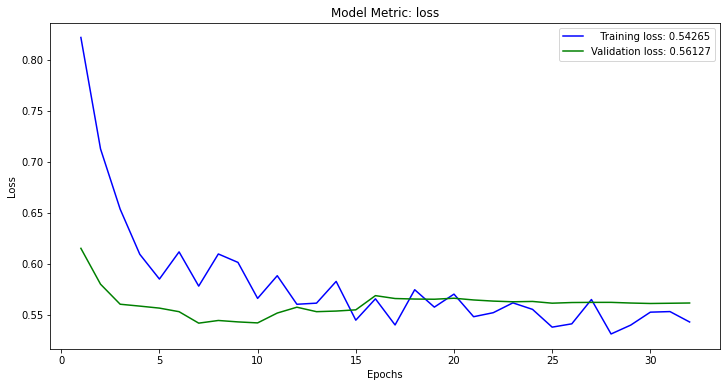

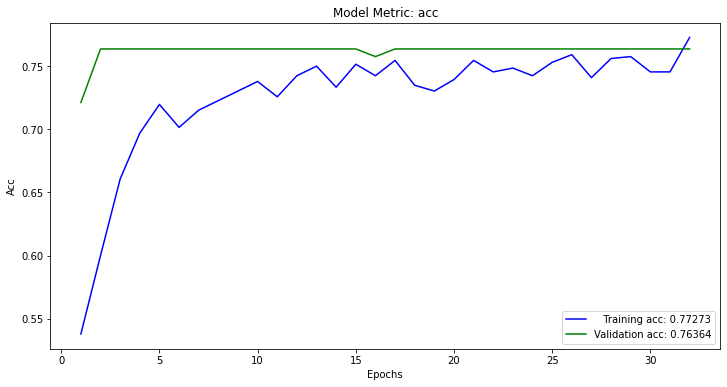

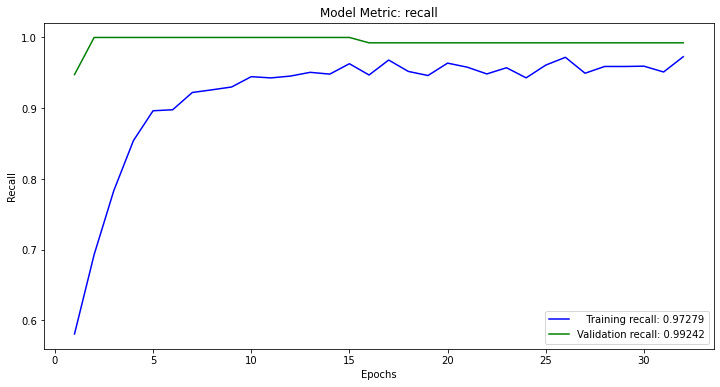

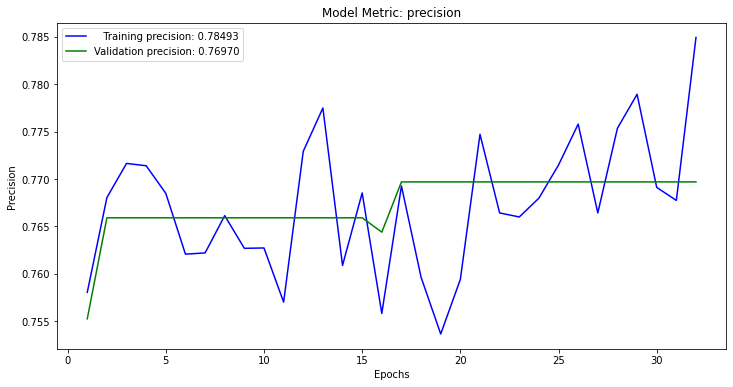

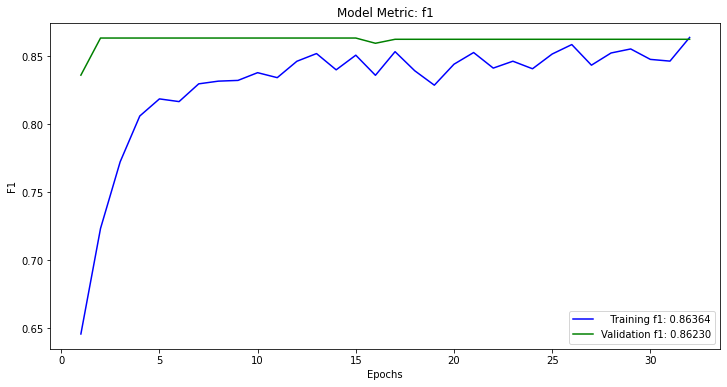

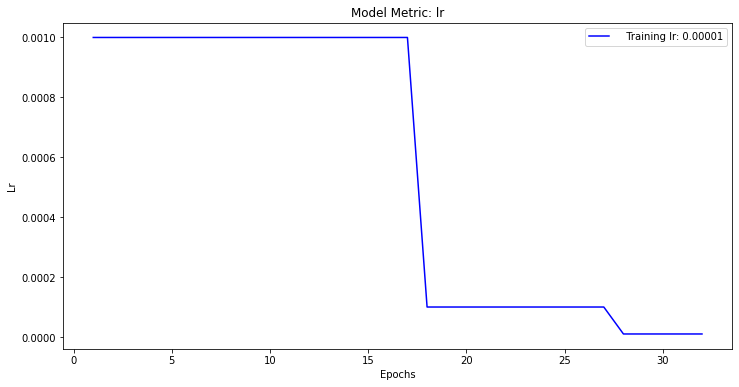

6/6 [==============================] - 0s 4ms/step - loss: 0.5415 - acc: 0.7636 - recall: 1.0000 - precision: 0.7688 - f1: 0.8674

--------------------------------------------------


Binary Crossentropy for model: 54.152 %

Accuracy for model: 76.364 %

Recall for model: 100.000 %

Precision for model: 76.875 %

F1 for model: 86.738 %

--------------------------------------------------


--------------------------------------------------

Fitting Random Forests CLF

--------------------------------------------------

Fitting Logistic Regression CLF

--------------------------------------------------



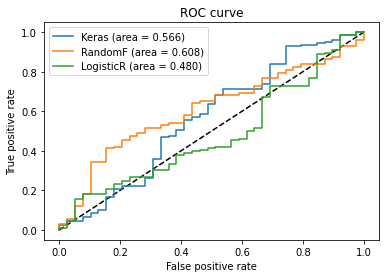


--------------------------------------------------

Study probability: 59.708 %


1

In [42]:
# Define Keras Callbacks

keras_callbacks = [ 
             EarlyStopping( 
                 monitor = 'val_loss', 
                 min_delta = 0.0001,
                 mode='min',
                 patience = 25, 
                 restore_best_weights = True,
                 verbose = 1, 
                 ), 

             ModelCheckpoint( 
                 filepath='noembed_mlp_adam_h5', 
                 monitor='val_loss', 
                 mode='min',
                 save_best_only = True, 
                 save_weights_only = False,
                 verbose = 1 
                 ), 

             ReduceLROnPlateau( 
                 monitor = 'val_loss', 
                 factor = 0.1, 
                 patience = 10, 
                 verbose = 1 
                 ) 
             ]

# Define The Neural Network Model

# define an empty sequential structure
noembed_mlp_adam_model = Sequential()

# Input layer
noembed_mlp_adam_model.add(Dense(32, input_dim=x_train.shape[1]))
noembed_mlp_adam_model.add(BatchNormalization())
noembed_mlp_adam_model.add(Activation('relu'))
noembed_mlp_adam_model.add(Dropout(0.3))

# Hidden layer    
noembed_mlp_adam_model.add(Dense(64))
noembed_mlp_adam_model.add(Activation('relu'))
noembed_mlp_adam_model.add(BatchNormalization())
noembed_mlp_adam_model.add(Dropout(0.3))

# Hidden layer    
noembed_mlp_adam_model.add(Dense(64))
noembed_mlp_adam_model.add(Activation('relu'))
noembed_mlp_adam_model.add(BatchNormalization())
noembed_mlp_adam_model.add(Dropout(0.3))

# Hidden layer    
noembed_mlp_adam_model.add(Dense(64))
noembed_mlp_adam_model.add(Activation('relu'))
noembed_mlp_adam_model.add(BatchNormalization())
noembed_mlp_adam_model.add(Dropout(0.3))

# Output Layer
noembed_mlp_adam_model.add(BatchNormalization())
# noembed_mlp_adam_model.add(Dropout(0.3))
noembed_mlp_adam_model.add(Dense(1,  activation = 'sigmoid'))

add_space()
noembed_mlp_adam_model.summary()

add_space()
plot_model(
    noembed_mlp_adam_model, 
    to_file='noembed_mlp_adam_model_plot.png', 
    show_shapes=True, 
    show_layer_names=True
    )

add_space()
print('Compiling Model..')

# Compile model
noembed_mlp_adam_model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['acc', recall, precision, f1]
    )

add_space()
print('Fitting Model..')
# Model Fit
history_noembed_mlp_adam_model = noembed_mlp_adam_model.fit(
    x_train, y_train, 
    epochs=250, batch_size=16, 
    validation_data=(x_val, y_val), 
    verbose = 1, callbacks= keras_callbacks, shuffle = True 
    )

add_space()
pprint(history_noembed_mlp_adam_model.history)

add_space()
plot_keras_history(history_noembed_mlp_adam_model)

# Model Evaluation
score_noembed_mlp_adam_model = noembed_mlp_adam_model.evaluate( 
    x_val, y_val, 
    batch_size=32, 
    verbose=1
    )

add_space()
print('\nBinary Crossentropy for model: {:.3f} %'.format(score_noembed_mlp_adam_model[0]*100))
print('\nAccuracy for model: {:.3f} %'.format(score_noembed_mlp_adam_model[1]*100))
print('\nRecall for model: {:.3f} %'.format(score_noembed_mlp_adam_model[2]*100))
print('\nPrecision for model: {:.3f} %'.format(score_noembed_mlp_adam_model[3]*100))
print('\nF1 for model: {:.3f} %'.format(score_noembed_mlp_adam_model[4]*100))


add_space()
# Model Prediction
y_pred_keras = noembed_mlp_adam_model.predict(x_val).ravel()
add_space()

print('Fitting Random Forests CLF')
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=50)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict_proba(x_val)[:, 1]

add_space()
print('Fitting Logistic Regression CLF')
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred_lr = lr.predict_proba(x_val)[:, 1]

add_space()
plot_binary_class_row_auc(
    y_true=y_val, 
    clf_names=['Keras', 'RandomF', 'LogisticR'], 
    clfs_preds=[y_pred_keras, y_pred_rf, y_pred_lr])

noembed_mlp_adam_model_text = 'Clean fuels for resource-poor settings: A systematic review of barriers and enablers to adoption and sustained use' \
'Access to, and sustained adoption of, clean household fuels at scale remains an aspirational goal to achieve sufficient reductions in household air pollution (HAP) in order to impact on the substantial global health burden caused by reliance on solid fuels.' \
'To systematically appraise the current evidence base to identify: (i) which factors enable or limit adoption and sustained use of clean fuels (namely liquefied petroleum gas (LPG), biogas, solar cooking and alcohol fuels) in low- and middle-income countries; (ii) lessons learnt concerning equitable scaling-up of programmes of cleaner cooking fuels in relation to poverty, urbanâ€“rural settings and gender.' \
'A mixed-methods systematic review was conducted using established review methodology and extensive searches of published and grey literature sources.' \
'Data extraction and quality appraisal of quantitative, qualitative and case studies meeting inclusion criteria were conducted using standardised methods with reliability checking.' \
'Forty-four studies from Africa, Asia and Latin America met the inclusion criteria (17 on biogas, 12 on LPG, 9 on solar, 6 on alcohol fuels).' \
'A broad range of inter-related enabling and limiting factors were identified for all four types of intervention, operating across seven pre-specified domains (i.e.' \
'fuel and technology characteristics, household and setting characteristics, knowledge and perceptions, financial, tax and subsidy aspects, market development, regulation, legislation and standards, and programme and policy mechanisms) and multiple levels (i.e.' \
'household, community, national).' \
'All domains matter and the majority of factors are common to all clean fuels interventions reviewed although some are fuel and technology-specific.' \
'All factors should therefore be taken into account and carefully assessed during planning and implementation of any small- and large-scale initiative aiming at promoting clean fuels for household cooking.' \
'Despite limitations in quantity and quality of the evidence this systematic review provides a useful starting point for the design, delivery and evaluation of programmes to ensure more effective adoption and use of LPG, biogas, alcohol fuels and solar cooking.' \
'This review was funded by the Department for International Development (DfID) of the United Kingdom.' \
'The authors would also like to thank the Evidence for Policy and Practice Information and Co-ordinating Centre (EPPI-Centre) for their technical support.' \

add_space()
predict_new_comment(
    text=noembed_mlp_adam_model_text, 
    tokenizer=tokenizer, 
    seq_max_length=maxlen, 
    model=noembed_mlp_adam_model
    )

## Model 3
- Hidden Layers: 4
- Neurons: 64, 128
- Dropout: 0.4
- BatchNormalization
- Optimizer: SGD


--------------------------------------------------

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                12864     
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
activation_7 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               8320      
_________________________________________________________________
activation_8 (Activation)    (None, 128)               0         
_________________________________________________________________
b

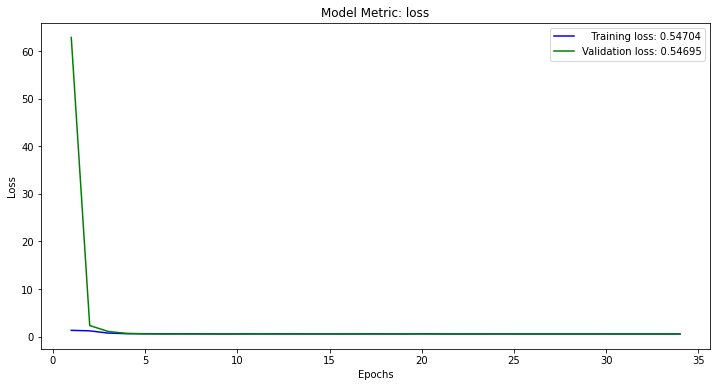

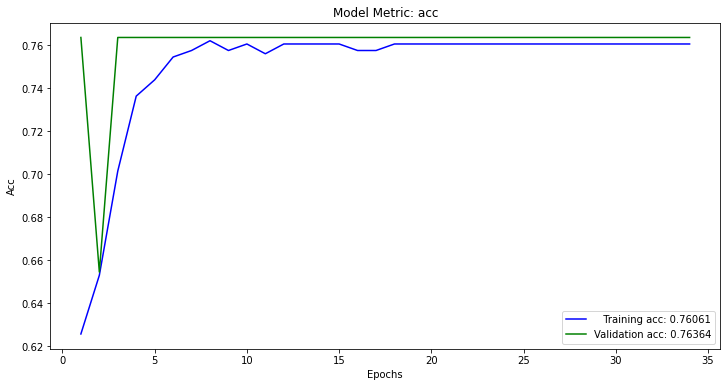

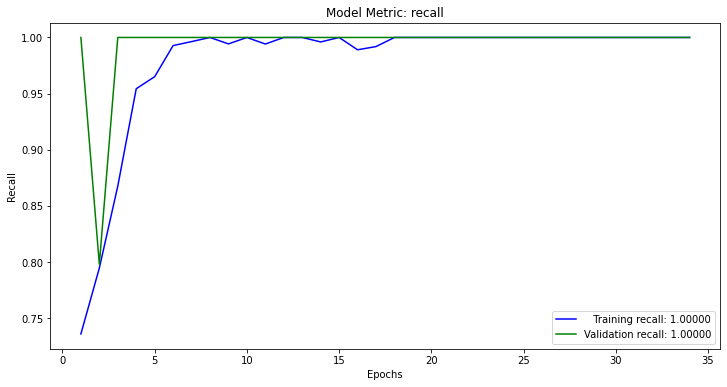

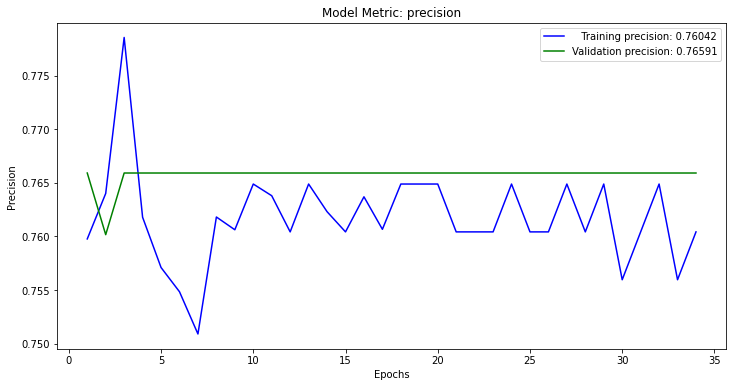

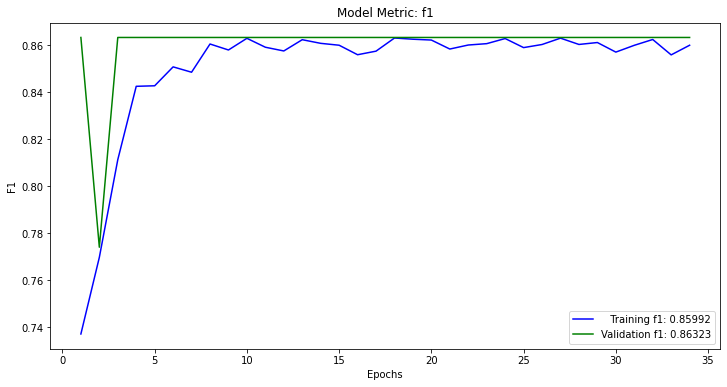

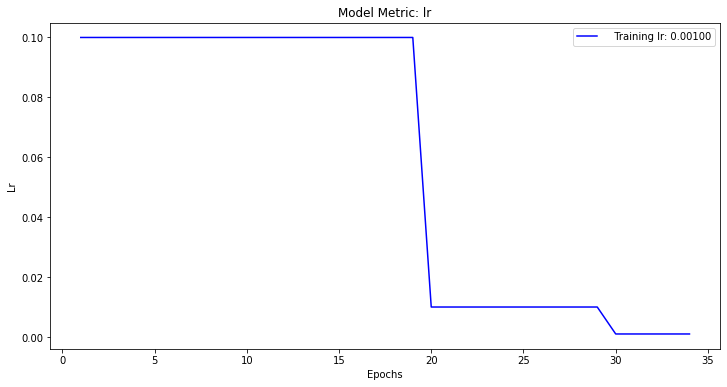

6/6 [==============================] - 0s 4ms/step - loss: 0.5438 - acc: 0.7636 - recall: 1.0000 - precision: 0.7688 - f1: 0.8674

--------------------------------------------------


Binary Crossentropy for model: 54.378 %

Accuracy for model: 76.364 %

Recall for model: 100.000 %

Precision for model: 76.875 %

F1 for model: 86.738 %

--------------------------------------------------


--------------------------------------------------

Fitting Random Forests CLF

--------------------------------------------------

Fitting Logistic Regression CLF

--------------------------------------------------



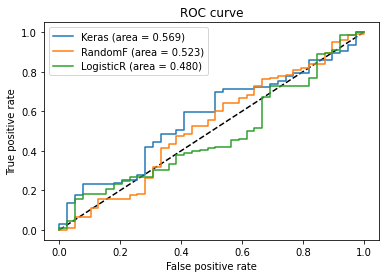


--------------------------------------------------

Study probability: 78.032 %


1

In [43]:
# Define Keras Callbacks

keras_callbacks = [ 
             EarlyStopping( 
                 monitor = 'val_loss', 
                 min_delta = 0.0001,
                 mode='min',
                 patience = 25, 
                 restore_best_weights = True,
                 verbose = 1, 
                 ), 

             ModelCheckpoint( 
                 filepath='noembed_mlp_deep_sgd_h5', 
                 monitor='val_loss', 
                 mode='min',
                 save_best_only = True, 
                 save_weights_only = False,
                 verbose = 1 
                 ), 

             ReduceLROnPlateau( 
                 monitor = 'val_loss', 
                 factor = 0.1, 
                 patience = 10, 
                 verbose = 1 
                 ) 
             ]

# Define The Neural Network Model

# define an empty sequential structure
noembed_mlp_deep_sgd_model = Sequential()

# Input layer
noembed_mlp_deep_sgd_model.add(Dense(64, input_dim=x_train.shape[1]))
noembed_mlp_deep_sgd_model.add(BatchNormalization())
noembed_mlp_deep_sgd_model.add(Activation('relu'))
noembed_mlp_deep_sgd_model.add(Dropout(0.4))

# Hidden layer    
noembed_mlp_deep_sgd_model.add(Dense(128))
noembed_mlp_deep_sgd_model.add(Activation('relu'))
noembed_mlp_deep_sgd_model.add(BatchNormalization())
noembed_mlp_deep_sgd_model.add(Dropout(0.4))

# Hidden layer    
noembed_mlp_deep_sgd_model.add(Dense(128))
noembed_mlp_deep_sgd_model.add(Activation('relu'))
noembed_mlp_deep_sgd_model.add(BatchNormalization())
noembed_mlp_deep_sgd_model.add(Dropout(0.4))

# Hidden layer    
noembed_mlp_deep_sgd_model.add(Dense(128))
noembed_mlp_deep_sgd_model.add(Activation('relu'))
noembed_mlp_deep_sgd_model.add(BatchNormalization())
noembed_mlp_deep_sgd_model.add(Dropout(0.4))

# Hidden layer    
noembed_mlp_deep_sgd_model.add(Dense(128))
noembed_mlp_deep_sgd_model.add(Activation('relu'))
noembed_mlp_deep_sgd_model.add(BatchNormalization())
noembed_mlp_deep_sgd_model.add(Dropout(0.4))

# Output Layer
noembed_mlp_deep_sgd_model.add(BatchNormalization())
noembed_mlp_deep_sgd_model.add(Dropout(0.4))
noembed_mlp_deep_sgd_model.add(Dense(1,  activation = 'sigmoid'))

add_space()
noembed_mlp_deep_sgd_model.summary()

add_space()
plot_model(
    noembed_mlp_deep_sgd_model, 
    to_file='noembed_mlp_deep_sgd_model_plot.png', 
    show_shapes=True, 
    show_layer_names=True
    )

add_space()
print('Compiling Model..')

# Setting up the optimization of our weights 
sgd = SGD(lr=0.1,
          decay=1e-6,
          momentum=0.9,
          nesterov=True)

# Compile model
noembed_mlp_deep_sgd_model.compile(
    loss='binary_crossentropy', 
    optimizer=sgd, 
    metrics=['acc', recall, precision, f1]
    )

add_space()
print('Fitting Model..')
# Model Fit
history_noembed_mlp_deep_sgd_model = noembed_mlp_deep_sgd_model.fit(
    x_train, y_train, 
    epochs=250, batch_size=16, 
    validation_data=(x_val, y_val), 
    verbose = 1, callbacks= keras_callbacks, shuffle = True 
    )

add_space()
pprint(history_noembed_mlp_deep_sgd_model.history)

add_space()
plot_keras_history(history_noembed_mlp_deep_sgd_model)

# Model Evaluation
score_noembed_mlp_deep_sgd_model = noembed_mlp_deep_sgd_model.evaluate( 
    x_val, y_val, 
    batch_size=32, 
    verbose=1
    )

add_space()
print('\nBinary Crossentropy for model: {:.3f} %'.format(score_noembed_mlp_deep_sgd_model[0]*100))
print('\nAccuracy for model: {:.3f} %'.format(score_noembed_mlp_deep_sgd_model[1]*100))
print('\nRecall for model: {:.3f} %'.format(score_noembed_mlp_deep_sgd_model[2]*100))
print('\nPrecision for model: {:.3f} %'.format(score_noembed_mlp_deep_sgd_model[3]*100))
print('\nF1 for model: {:.3f} %'.format(score_noembed_mlp_deep_sgd_model[4]*100))


add_space()
# Model Prediction
y_pred_keras = noembed_mlp_deep_sgd_model.predict(x_val).ravel()
add_space()

print('Fitting Random Forests CLF')
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=50)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict_proba(x_val)[:, 1]

add_space()
print('Fitting Logistic Regression CLF')
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred_lr = lr.predict_proba(x_val)[:, 1]

add_space()
plot_binary_class_row_auc(
    y_true=y_val, 
    clf_names=['Keras', 'RandomF', 'LogisticR'], 
    clfs_preds=[y_pred_keras, y_pred_rf, y_pred_lr])

noembed_mlp_deep_sgd_model_text = 'Adverse health impacts of cooking with kerosene: A multi-country analysis within the Prospective Urban and Rural Epidemiology Study' \
'Kerosene, which was until recently considered a relatively clean household fuel, is still widely used in low- and middle-income countries for cooking and lighting.' \
'However, there is little data on its health effects.' \
'We examined cardiorespiratory effects and mortality in households using kerosene as their primary cooking fuel within the Prospective Urban Rural Epidemiology (PURE) study.' \
'We analyzed baseline and follow-up data on 31,490 individuals from 154 communities in China, India, South Africa, and Tanzania where there was at least 10% kerosene use for cooking at baseline.' \
'Baseline comorbidities and health outcomes during follow-up (median 9.4 years) were compared between households with kerosene versus clean (gas or electricity) or solid fuel (biomass and coal) use for cooking.' \
'Multi-level marginal regression models adjusted for individual, household, and community level covariates.' \
'Higher rates of prevalent respiratory symptoms (e.g.' \
'34% [95% CI:15â€“57%] more dyspnea with usual activity, 44% [95% CI: 21â€“72%] more chronic cough or sputum) and lower lung function (differences in FEV1: âˆ’46.3 ml (95% CI: âˆ’80.5; âˆ’12.1) and FVC: âˆ’54.7 ml (95% CI: âˆ’93.6; âˆ’15.8)) were observed at baseline for kerosene compared to clean fuel users.' \
'The odds of hypertension was slightly elevated but no associations were observed for blood pressure.' \
'Prospectively, kerosene was associated with elevated risks of all-cause (HR: 1.32 (95% CI: 1.14-1.53)) and cardiovascular (HR: 1.34 (95% CI: 1.00-1.80)) mortality, as well as major fatal and incident non-fatal cardiovascular (HR: 1.34 (95% CI: 1.08-1.66)) and respiratory (HR: 1.55 (95% CI: 0.98-2.43)) diseases, compared to clean fuel use.' \
'Further, compared to solid fuel users, those using kerosene had 20â€“47% higher risks for the above outcomes.' \
'Kerosene use for cooking was associated with higher rates of baseline respiratory morbidity and increased risk of mortality and cardiorespiratory outcomes during follow-up when compared to either clean or solid fuels.' \
'Replacing kerosene with cleaner-burning fuels for cooking is recommended.' \

add_space()
predict_new_comment(
    text=noembed_mlp_deep_sgd_model_text, 
    tokenizer=tokenizer, 
    seq_max_length=maxlen, 
    model=noembed_mlp_deep_sgd_model
    )

# MLP - Self-trained Embeddings

## Model 1
- Hidden Layers: 2
- Neurons: 8, 16
- Dropout: 0.3
- Optimizer: Nadam


--------------------------------------------------

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 50)           250000    
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 80008     
_________________________________________________________________
activation_12 (Activation)   (None, 8)                 0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                144       
_________________________________________________________________
a

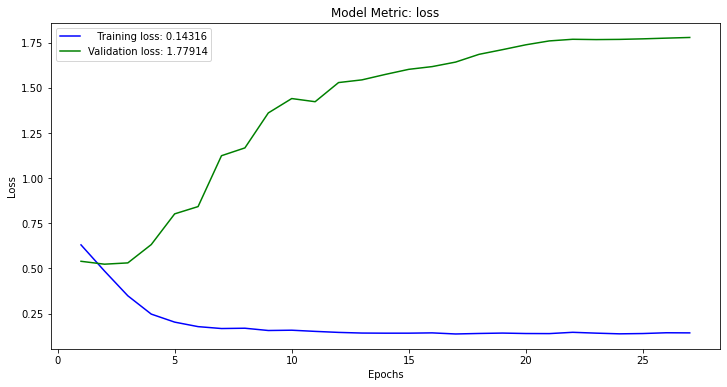

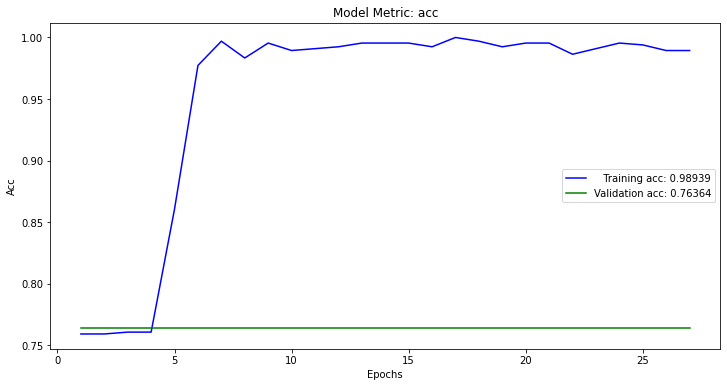

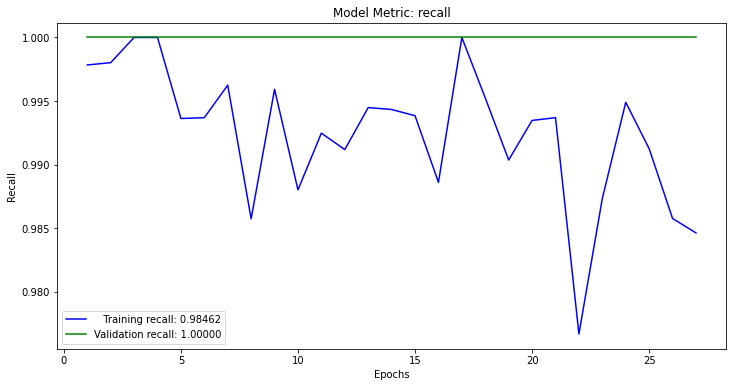

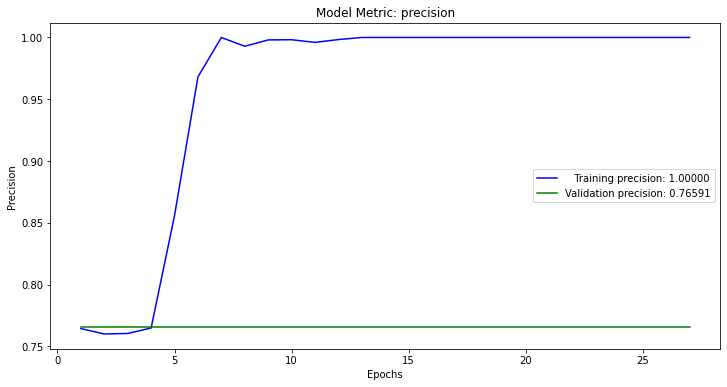

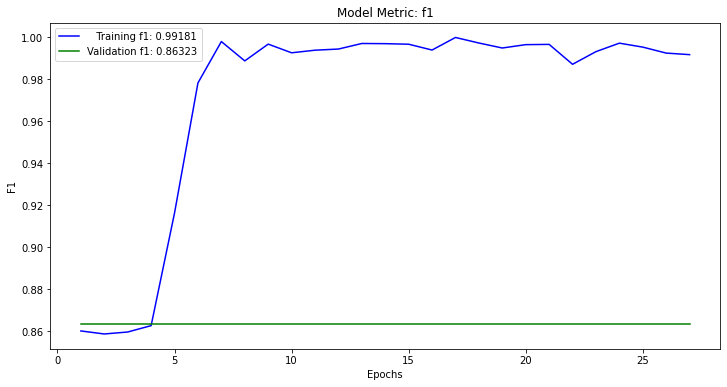

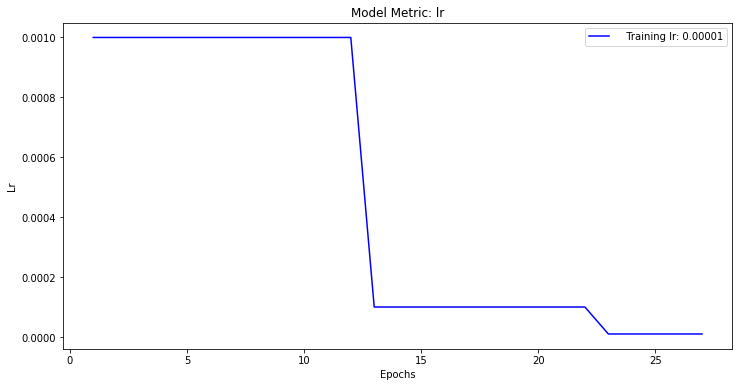

6/6 [==============================] - 0s 4ms/step - loss: 0.5236 - acc: 0.7636 - recall: 1.0000 - precision: 0.7688 - f1: 0.8674

--------------------------------------------------


Binary Crossentropy for model: 52.358 %

Accuracy for model: 76.364 %

Recall for model: 100.000 %

Precision for model: 76.875 %

F1 for model: 86.738 %

--------------------------------------------------


--------------------------------------------------

Fitting Random Forests CLF

--------------------------------------------------

Fitting Logistic Regression CLF

--------------------------------------------------



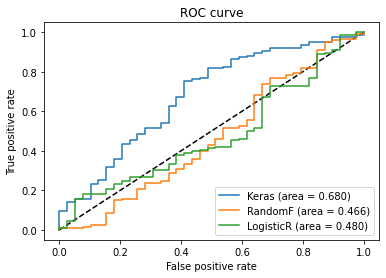


--------------------------------------------------

Study probability: 80.851 %


1

In [44]:
# Define Keras Callbacks

keras_callbacks = [ 
             EarlyStopping( 
                 monitor = 'val_loss', 
                 min_delta = 0.0001,
                 mode='min',
                 patience = 25, 
                 restore_best_weights = True,
                 verbose = 1, 
                 ), 

             ModelCheckpoint( 
                 filepath='selfembed_mlp_baseadam_h5', 
                 monitor='val_loss', 
                 mode='min',
                 save_best_only = True, 
                 save_weights_only = False,
                 verbose = 1 
                 ), 

             ReduceLROnPlateau( 
                 monitor = 'val_loss', 
                 factor = 0.1, 
                 patience = 10, 
                 verbose = 1 
                 ) 
             ]

# Define The Neural Network Model

# Define an empty sequential structure
selfembed_mlp_baseadam_model = Sequential()

# Self-Embedding Layer
selfembed_mlp_baseadam_model.add(Embedding(
    input_dim = max_words, 
    output_dim = self_embedding_dim , 
    embeddings_initializer = 'uniform', 
    trainable = True,
    mask_zero = True, 
    input_length = maxlen
    )
)

selfembed_mlp_baseadam_model.add(Flatten())

# Input layer
selfembed_mlp_baseadam_model.add(Dense(8, input_dim=x_train.shape[1]))
selfembed_mlp_baseadam_model.add(Activation('relu'))
selfembed_mlp_baseadam_model.add(Dropout(0.2))

# Hidden layer    
selfembed_mlp_baseadam_model.add(Dense(16))
selfembed_mlp_baseadam_model.add(Activation('relu'))
selfembed_mlp_baseadam_model.add(Dropout(0.3))

# Hidden layer    
selfembed_mlp_baseadam_model.add(Dense(16))
selfembed_mlp_baseadam_model.add(Activation('relu'))
selfembed_mlp_baseadam_model.add(Dropout(0.3))

# Output Layer
selfembed_mlp_baseadam_model.add(Dense(1,  activation = 'sigmoid'))

add_space()
selfembed_mlp_baseadam_model.summary()

add_space()
plot_model(
    selfembed_mlp_baseadam_model, 
    to_file='selfembed_mlp_baseadam_model_plot.png', 
    show_shapes=True, 
    show_layer_names=True
    )

add_space()
print('Compiling Model..')

# Compile model
selfembed_mlp_baseadam_model.compile(
    loss='binary_crossentropy', 
    optimizer='nadam', 
    metrics=['acc', recall, precision, f1]
    )

add_space()
print('Fitting Model..')
# Model Fit
history_selfembed_mlp_baseadam_model = selfembed_mlp_baseadam_model.fit(
    x_train, y_train, epochs=250, batch_size=16, 
    validation_data=(x_val, y_val), verbose = 1, 
    callbacks= keras_callbacks, shuffle = True 
    )

add_space()
pprint(history_selfembed_mlp_baseadam_model.history)

add_space()
plot_keras_history(history_selfembed_mlp_baseadam_model)

# Model Evaluation
score_selfembed_mlp_baseadam_model = selfembed_mlp_baseadam_model.evaluate( 
    x_val, y_val, 
    batch_size=32, 
    verbose=1
    )

add_space()
print('\nBinary Crossentropy for model: {:.3f} %'.format(score_selfembed_mlp_baseadam_model[0]*100))
print('\nAccuracy for model: {:.3f} %'.format(score_selfembed_mlp_baseadam_model[1]*100))
print('\nRecall for model: {:.3f} %'.format(score_selfembed_mlp_baseadam_model[2]*100))
print('\nPrecision for model: {:.3f} %'.format(score_selfembed_mlp_baseadam_model[3]*100))
print('\nF1 for model: {:.3f} %'.format(score_selfembed_mlp_baseadam_model[4]*100))


add_space()
# Model Prediction
y_pred_keras = selfembed_mlp_baseadam_model.predict(x_val).ravel()
add_space()

print('Fitting Random Forests CLF')
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=50)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict_proba(x_val)[:, 1]

add_space()
print('Fitting Logistic Regression CLF')
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred_lr = lr.predict_proba(x_val)[:, 1]

add_space()
plot_binary_class_row_auc(
    y_true=y_val, 
    clf_names=['Keras', 'RandomF', 'LogisticR'], 
    clfs_preds=[y_pred_keras, y_pred_rf, y_pred_lr])

selfembed_mlp_baseadam_model_text = 'Effect of hydrogen supplementation on engine performance and emissions' \
'Abstract Vehicular Pollution and environmental degradation are on the rise with increasing vehicles and to stop this strict regulation have been put on vehicular emissions.' \
'Also, the depleting fossil fuels are of great concern for energy security.' \
'This has motivated the researchers to invest considerable resources in finding cleaner burning, sustainable and renewable fuels.' \
'However renewable fuels independently are not sufficient to deal with the problem at hand due to supply constraints.' \
'Hence, advanced combustion technologies such as homogeneous charge compression ignition (HCCI), low-temperature combustion (LTC), and dual fuel engines are extensively researched upon.' \
'In this context, this work investigates dual fuel mode combustion using a constant speed diesel engine, operated using hydrogen and diesel.' \
'The engine is operated at 25, 50 and 75% loads and substitution of diesel energy with hydrogen energy is done as 0, 5, 10 and 20%.' \
'The effect of hydrogen energy share (HES) enhancement on engine performance and emissions is investigated.' \
'In the tested range, slightly detrimental effect of HES on brake thermal efficiency (BTE) and brake specific fuel consumption (BSFC) is observed.' \
'Comparision of NO and NO2 emissions is done to understand the non-thermal influence of H2 on the NOx emissions.' \
'Hence, HES is found beneficial in reducing harmful emissions at low and mid loads.' \

add_space()
predict_new_comment(
    text=selfembed_mlp_baseadam_model_text, 
    tokenizer=tokenizer, 
    seq_max_length=maxlen, 
    model=selfembed_mlp_baseadam_model
    )

## Model 2
- Hidden Layers: 3
- Neurons: 32, 64
- Dropout: 0.4
- BatchNormalization
- Optimizer: Adam


--------------------------------------------------

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 50)           250000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                320032    
_________________________________________________________________
batch_normalization_11 (Batc (None, 32)                128       
_________________________________________________________________
activation_15 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
d

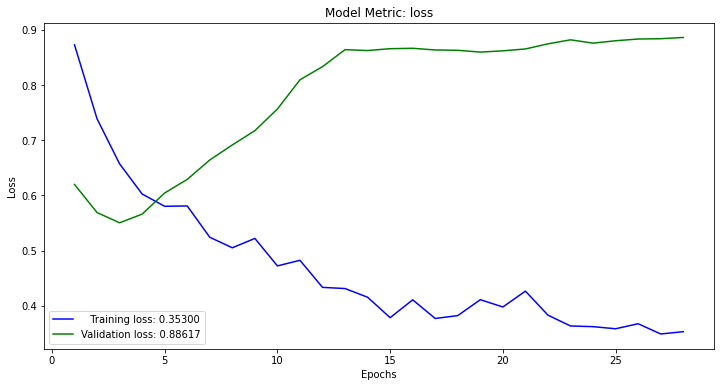

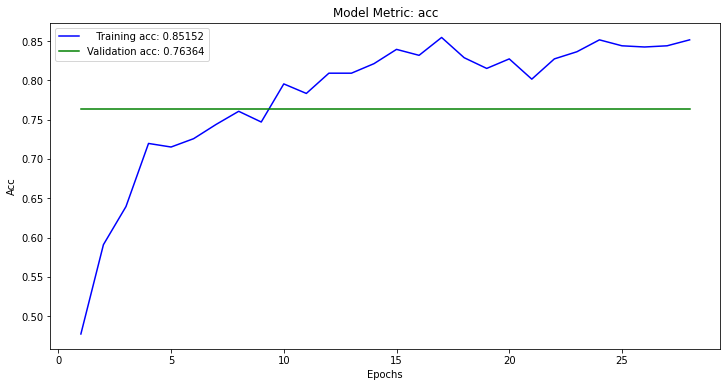

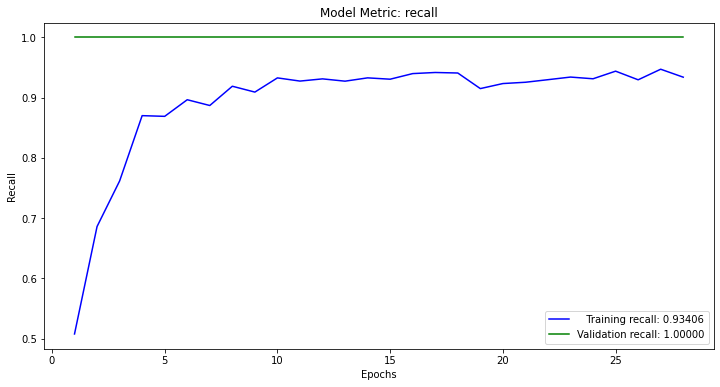

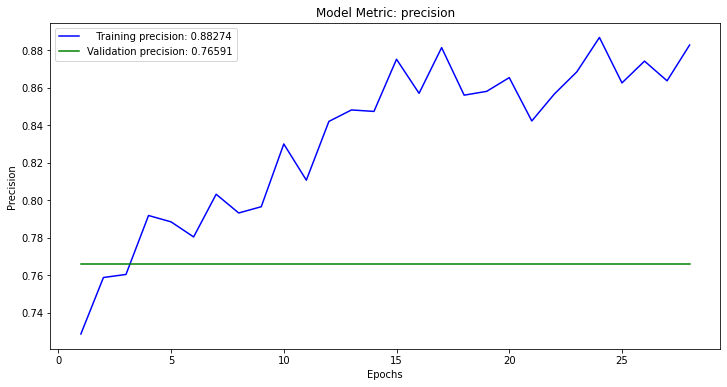

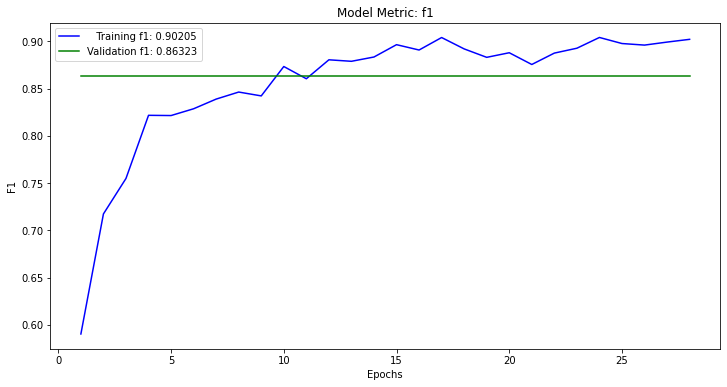

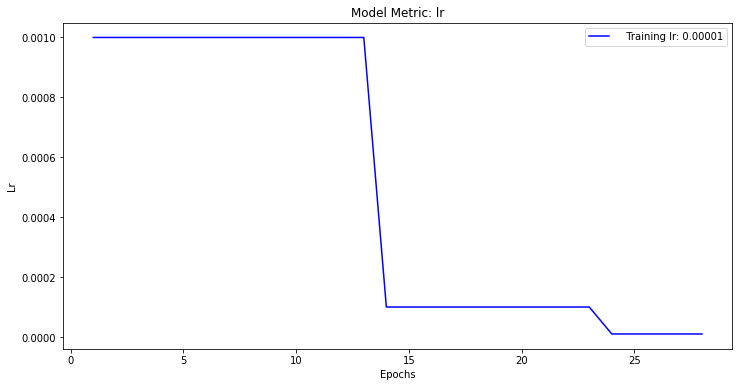

6/6 [==============================] - 0s 4ms/step - loss: 0.5503 - acc: 0.7636 - recall: 1.0000 - precision: 0.7688 - f1: 0.8674

--------------------------------------------------


Binary Crossentropy for model: 55.032 %

Accuracy for model: 76.364 %

Recall for model: 100.000 %

Precision for model: 76.875 %

F1 for model: 86.738 %

--------------------------------------------------


--------------------------------------------------

Fitting Random Forests CLF

--------------------------------------------------

Fitting Logistic Regression CLF

--------------------------------------------------



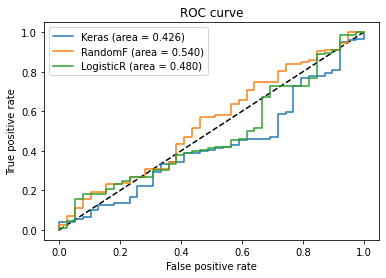


--------------------------------------------------

Study probability: 76.902 %


1

In [45]:
# Define Keras Callbacks

keras_callbacks = [ 
             EarlyStopping( 
                 monitor = 'val_loss', 
                 min_delta = 0.0001,
                 mode='min',
                 patience = 25, 
                 restore_best_weights = True,
                 verbose = 1, 
                 ), 

             ModelCheckpoint( 
                 filepath='selfembed_mlp_adam_h5', 
                 monitor='val_loss', 
                 mode='min',
                 save_best_only = True, 
                 save_weights_only = False,
                 verbose = 1 
                 ), 

             ReduceLROnPlateau( 
                 monitor = 'val_loss', 
                 factor = 0.1, 
                 patience = 10, 
                 verbose = 1 
                 ) 
             ]

# Define The Neural Network Model

# define an empty sequential structure
selfembed_mlp_adam_model = Sequential()

# Self-Embedding Layer
selfembed_mlp_adam_model.add(Embedding(
    input_dim = max_words, 
    output_dim = self_embedding_dim , 
    embeddings_initializer = 'uniform', 
    trainable = True,
    mask_zero = True, 
    input_length = maxlen
    )
)

selfembed_mlp_adam_model.add(Flatten())

# Input layer
selfembed_mlp_adam_model.add(Dense(32, input_dim=x_train.shape[1]))
selfembed_mlp_adam_model.add(BatchNormalization())
selfembed_mlp_adam_model.add(Activation('relu'))
selfembed_mlp_adam_model.add(Dropout(0.4))

# Hidden layer    
selfembed_mlp_adam_model.add(Dense(64))
selfembed_mlp_adam_model.add(Activation('relu'))
selfembed_mlp_adam_model.add(BatchNormalization())
selfembed_mlp_adam_model.add(Dropout(0.4))

# Hidden layer    
selfembed_mlp_adam_model.add(Dense(64))
selfembed_mlp_adam_model.add(Activation('relu'))
selfembed_mlp_adam_model.add(BatchNormalization())
selfembed_mlp_adam_model.add(Dropout(0.4))

# Hidden layer    
selfembed_mlp_adam_model.add(Dense(64))
selfembed_mlp_adam_model.add(Activation('relu'))
selfembed_mlp_adam_model.add(BatchNormalization())
selfembed_mlp_adam_model.add(Dropout(0.4))

# Output Layer
selfembed_mlp_adam_model.add(BatchNormalization())
# selfembed_mlp_adam_model.add(Dropout(0.4))
selfembed_mlp_adam_model.add(Dense(1,  activation = 'sigmoid'))

add_space()
selfembed_mlp_adam_model.summary()

add_space()
plot_model(
    selfembed_mlp_adam_model, 
    to_file='selfembed_mlp_adam_model_plot.png', 
    show_shapes=True, 
    show_layer_names=True
    )

add_space()
print('Compiling Model..')

# Compile model
selfembed_mlp_adam_model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['acc', recall, precision, f1]
    )

add_space()
print('Fitting Model..')
# Model Fit
history_selfembed_mlp_adam_model = selfembed_mlp_adam_model.fit(
    x_train, y_train, 
    epochs=250, batch_size=16, 
    validation_data=(x_val, y_val), 
    verbose = 1, callbacks= keras_callbacks, shuffle = True 
    )

add_space()
pprint(history_selfembed_mlp_adam_model.history)

add_space()
plot_keras_history(history_selfembed_mlp_adam_model)

# Model Evaluation
score_selfembed_mlp_adam_model = selfembed_mlp_adam_model.evaluate( 
    x_val, y_val, 
    batch_size=32, 
    verbose=1
    )

add_space()
print('\nBinary Crossentropy for model: {:.3f} %'.format(score_selfembed_mlp_adam_model[0]*100))
print('\nAccuracy for model: {:.3f} %'.format(score_selfembed_mlp_adam_model[1]*100))
print('\nRecall for model: {:.3f} %'.format(score_selfembed_mlp_adam_model[2]*100))
print('\nPrecision for model: {:.3f} %'.format(score_selfembed_mlp_adam_model[3]*100))
print('\nF1 for model: {:.3f} %'.format(score_selfembed_mlp_adam_model[4]*100))


add_space()
# Model Prediction
y_pred_keras = selfembed_mlp_adam_model.predict(x_val).ravel()
add_space()

print('Fitting Random Forests CLF')
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=50)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict_proba(x_val)[:, 1]

add_space()
print('Fitting Logistic Regression CLF')
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred_lr = lr.predict_proba(x_val)[:, 1]

add_space()
plot_binary_class_row_auc(
    y_true=y_val, 
    clf_names=['Keras', 'RandomF', 'LogisticR'], 
    clfs_preds=[y_pred_keras, y_pred_rf, y_pred_lr])

selfembed_mlp_adam_model_text = 'Upcoming Power Crisis in India â€“ Increasing Electricity Demand' \
'In this world of modernization every country tries to increase their domestic production in order to increase GDP.' \
'India is one of them, in order to improve their economy with the help of make in India and similar schemes.' \
'In this development process, India is committed to sustainable development and minimal use of conventional energy resources.' \
'In order to reduce CO2and CFC emission India started to reduce fossil fuel dependency.' \
'It tries to convert their fossil fuel system into regenerative and renewable sources.' \
'India begins to install Solar and Wind power plants of huge capacity instead of their conventional thermal and nuclear power plants.' \
'With the emergence of new technologies such as Wireless charging systems, Electric Vehicles, Smart systems such as Smart Grid and Wireless Communication systems such as Internet of things (IoT).' \
'But here one thing is notable that due to these systems power consumption also increases, due to their heavy power ratings and lower efficiencies in case of Wireless systems (Charging and Communication).' \
'In 2018 India is closest to power demand and its supply but not greater or equal to the power demanded.' \
'India has announced that power production is surplus in current scenario.' \
'But due to introduction of these above systems lead to immense increase in power demand.' \
'If India has not taken any effective steps to increase their power production then it will suffers power crisis in upcoming decades.' \
'The new power plants have higher efficiencies, high durability and produces almost no emissions.' \
'India has considered 8% growth till 2020, but this consideration must have reviewed as soon as possible.In 2018-19 data says that India is 0.9% power deficit which is very good progress in power sector as in past data.' \
'But this percentage is going to increase in future.' \
'There is also increasing market for Electric Vehicles.' \
'Automobile manufacturing companies are trying to shift their production towards Electric Vehicles.' \
'Due to their high cost efficiencies, low vibrations as compared to engines, no emissions, less maintenance, Electric Vehicle is becoming popular these days.' \
'This ultimately results in tremendous increase in power demand.' \
'Mobile manufacturer companies always try to increase power capacity of Mobile Batteries in order to increase its backup and introduce the wireless charging feature.' \
'This also results in increase in power consumption.' \
'Intelligent home appliances are also introduced, these also consumes more power due to integration of remote control and advanced User Interfaces such as facial recognition.' \
'Voice control and Artificial Intelligence (AI) systems are also integrated to these devices.' \
'These systems are designed for higher capacities i.e.' \
'parallel processing and high speed processing to enable multitasking features.' \
'These systemsrequire more power than conventional systems.' \

add_space()
predict_new_comment(
    text=selfembed_mlp_adam_model_text, 
    tokenizer=tokenizer, 
    seq_max_length=maxlen, 
    model=selfembed_mlp_adam_model
    )

## Model 3
- Hidden Layers: 4
- Neurons: 64, 128
- Dropout: 0.5
- BatchNormalization
- Optimizer: SGD


--------------------------------------------------

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 50)           250000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                640064    
_________________________________________________________________
batch_normalization_16 (Batc (None, 64)                256       
_________________________________________________________________
activation_19 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
d

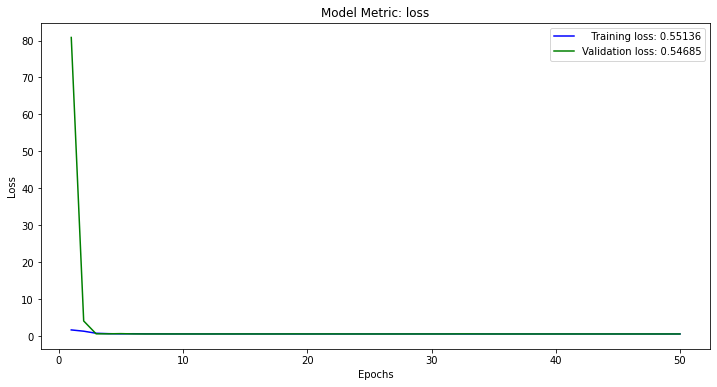

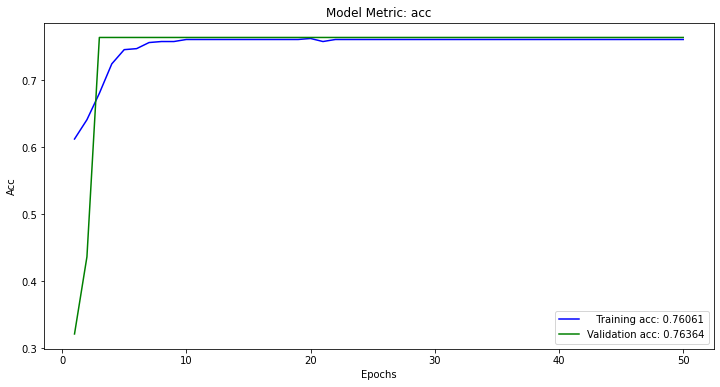

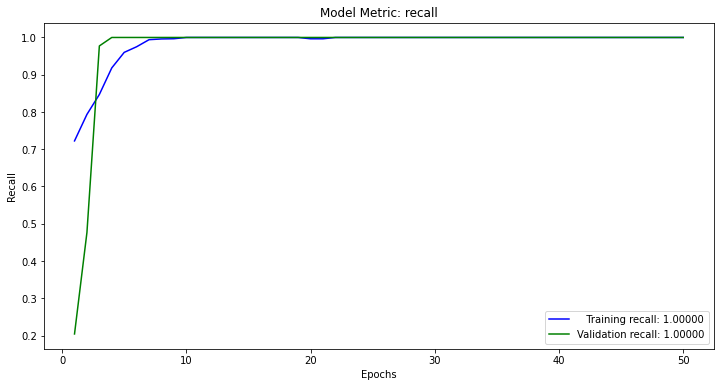

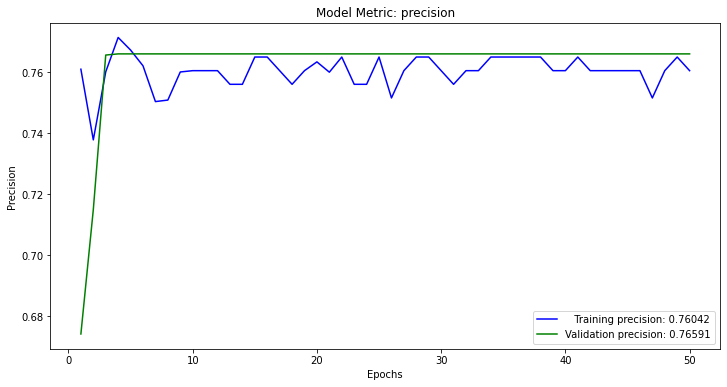

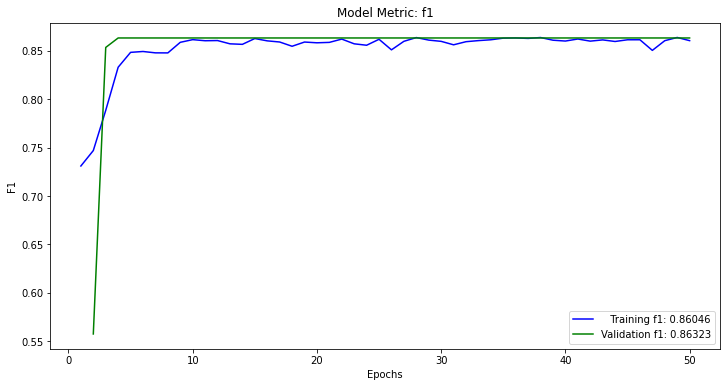

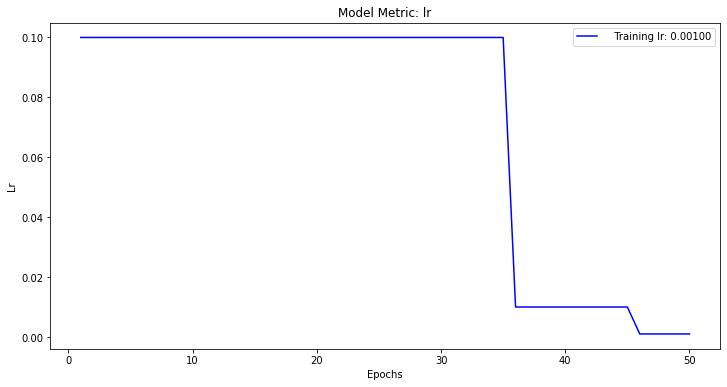

6/6 [==============================] - 0s 5ms/step - loss: 0.5457 - acc: 0.7636 - recall: 1.0000 - precision: 0.7688 - f1: 0.8674

--------------------------------------------------


Binary Crossentropy for model: 54.572 %

Accuracy for model: 76.364 %

Recall for model: 100.000 %

Precision for model: 76.875 %

F1 for model: 86.738 %

--------------------------------------------------


--------------------------------------------------

Fitting Random Forests CLF

--------------------------------------------------

Fitting Logistic Regression CLF

--------------------------------------------------



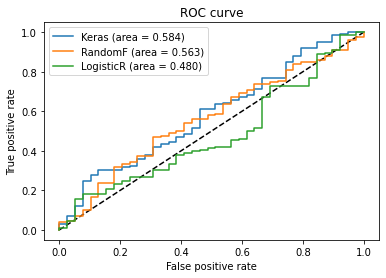


--------------------------------------------------

Study probability: 76.526 %


1

In [46]:
# Define Keras Callbacks

keras_callbacks = [ 
             EarlyStopping( 
                 monitor = 'val_loss', 
                 min_delta = 0.0001,
                 mode='min',
                 patience = 25, 
                 restore_best_weights = True,
                 verbose = 1, 
                 ), 

             ModelCheckpoint( 
                 filepath='selfembed_mlp_deep_sgd_h5', 
                 monitor='val_loss', 
                 mode='min',
                 save_best_only = True, 
                 save_weights_only = False,
                 verbose = 1 
                 ), 

             ReduceLROnPlateau( 
                 monitor = 'val_loss', 
                 factor = 0.1, 
                 patience = 10, 
                 verbose = 1 
                 ) 
             ]

# Define The Neural Network Model

# define an empty sequential structure
selfembed_mlp_deep_sgd_model = Sequential()

# Self-Embedding Layer
selfembed_mlp_deep_sgd_model.add(Embedding(
    input_dim = max_words, 
    output_dim = self_embedding_dim , 
    embeddings_initializer = 'uniform', 
    trainable = True,
    mask_zero = True, 
    input_length = maxlen
    )
)

selfembed_mlp_deep_sgd_model.add(Flatten())

# Input layer
selfembed_mlp_deep_sgd_model.add(Dense(64, input_dim=x_train.shape[1]))
selfembed_mlp_deep_sgd_model.add(BatchNormalization())
selfembed_mlp_deep_sgd_model.add(Activation('relu'))
selfembed_mlp_deep_sgd_model.add(Dropout(0.5))

# Hidden layer    
selfembed_mlp_deep_sgd_model.add(Dense(128))
selfembed_mlp_deep_sgd_model.add(Activation('relu'))
selfembed_mlp_deep_sgd_model.add(BatchNormalization())
selfembed_mlp_deep_sgd_model.add(Dropout(0.5))

# Hidden layer    
selfembed_mlp_deep_sgd_model.add(Dense(128))
selfembed_mlp_deep_sgd_model.add(Activation('relu'))
selfembed_mlp_deep_sgd_model.add(BatchNormalization())
selfembed_mlp_deep_sgd_model.add(Dropout(0.5))

# Hidden layer    
selfembed_mlp_deep_sgd_model.add(Dense(128))
selfembed_mlp_deep_sgd_model.add(Activation('relu'))
selfembed_mlp_deep_sgd_model.add(BatchNormalization())
selfembed_mlp_deep_sgd_model.add(Dropout(0.5))

# Hidden layer    
selfembed_mlp_deep_sgd_model.add(Dense(128))
selfembed_mlp_deep_sgd_model.add(Activation('relu'))
selfembed_mlp_deep_sgd_model.add(BatchNormalization())
selfembed_mlp_deep_sgd_model.add(Dropout(0.5))

# Output Layer
selfembed_mlp_deep_sgd_model.add(BatchNormalization())
selfembed_mlp_deep_sgd_model.add(Dropout(0.5))
selfembed_mlp_deep_sgd_model.add(Dense(1,  activation = 'sigmoid'))

add_space()
selfembed_mlp_deep_sgd_model.summary()

add_space()
plot_model(
    selfembed_mlp_deep_sgd_model, 
    to_file='selfembed_mlp_deep_sgd_model_plot.png', 
    show_shapes=True, 
    show_layer_names=True
    )

add_space()
print('Compiling Model..')

# Setting up the optimization of our weights 
sgd = SGD(lr=0.1,
          decay=1e-6,
          momentum=0.9,
          nesterov=True)

# Compile model
selfembed_mlp_deep_sgd_model.compile(
    loss='binary_crossentropy', 
    optimizer=sgd, 
    metrics=['acc', recall, precision, f1]
    )

add_space()
print('Fitting Model..')
# Model Fit
history_selfembed_mlp_deep_sgd_model = selfembed_mlp_deep_sgd_model.fit(
    x_train, y_train, 
    epochs=250, batch_size=16, 
    validation_data=(x_val, y_val), 
    verbose = 1, callbacks= keras_callbacks, shuffle = True 
    )

add_space()
pprint(history_selfembed_mlp_deep_sgd_model.history)

add_space()
plot_keras_history(history_selfembed_mlp_deep_sgd_model)

# Model Evaluation
score_selfembed_mlp_deep_sgd_model = selfembed_mlp_deep_sgd_model.evaluate( 
    x_val, y_val, 
    batch_size=32, 
    verbose=1
    )

add_space()
print('\nBinary Crossentropy for model: {:.3f} %'.format(score_selfembed_mlp_deep_sgd_model[0]*100))
print('\nAccuracy for model: {:.3f} %'.format(score_selfembed_mlp_deep_sgd_model[1]*100))
print('\nRecall for model: {:.3f} %'.format(score_selfembed_mlp_deep_sgd_model[2]*100))
print('\nPrecision for model: {:.3f} %'.format(score_selfembed_mlp_deep_sgd_model[3]*100))
print('\nF1 for model: {:.3f} %'.format(score_selfembed_mlp_deep_sgd_model[4]*100))


add_space()
# Model Prediction
y_pred_keras = selfembed_mlp_deep_sgd_model.predict(x_val).ravel()
add_space()

print('Fitting Random Forests CLF')
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=50)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict_proba(x_val)[:, 1]

add_space()
print('Fitting Logistic Regression CLF')
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred_lr = lr.predict_proba(x_val)[:, 1]

add_space()
plot_binary_class_row_auc(
    y_true=y_val, 
    clf_names=['Keras', 'RandomF', 'LogisticR'], 
    clfs_preds=[y_pred_keras, y_pred_rf, y_pred_lr])

selfembed_mlp_deep_sgd_model_text = 'How do oil prices, macroeconomic factors and policies affect the market for renewable energy?' \
'The aim of this study is to determine the nature of any relationship between renewable energy investment, oil prices, GDP and the interest rate, using a time series approach.' \
'We concentrate on three countries with different relationships with the renewable energy sector, with Norway and the UK being oil-exporters for most of the sample and the USA an importer.' \
'Following estimation using a VAR model, the results provide evidence of considerable heterogeneity across the countries, with the USA and Norway having a strong relationship between oil prices and renewable energy and the UK no relationship.' \
'These results reflect the fact that the USA is predominantly an oil-importer during most of this sample and supports renewable energy relatively less than the other countries, so changes to renewable energy investment reflect other factors in the market such as the price of substitutes to a greater extent than countries where renewable energy receives more government support.' \
'Similarly with Norway, where due to its market orientated approach, there is some evidence of the macroeconomy affecting the renewable energy market.' \
'The main policy implications from this study are that in countries where there is little support for the renewable energy sector, investment will be more dependent on macroeconomic aspects as well as substitutes such as oil, therefore the authorities will need to potentially increase financial support when oil prices are low or when the economy is in a downturn to ensure investment in RE continues at a constant level.' \

add_space()
predict_new_comment(
    text=selfembed_mlp_deep_sgd_model_text, 
    tokenizer=tokenizer, 
    seq_max_length=maxlen, 
    model=selfembed_mlp_deep_sgd_model
    )

# MLP - Pre-trained GloVe Embeddings

## Model 1
- Hidden Layers: 2
- Neurons: 32, 64
- Dropout: 0.5
- Optimizer: Nadam


--------------------------------------------------

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 100)          500000    
_________________________________________________________________
flatten_3 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 32)                640032    
_________________________________________________________________
activation_24 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 64)                2112      
_________________________________________________________________
a

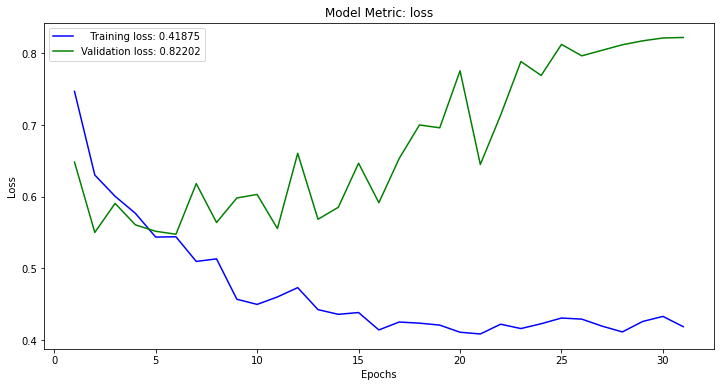

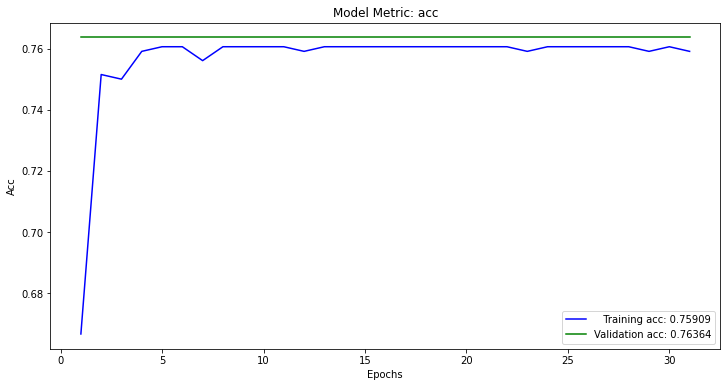

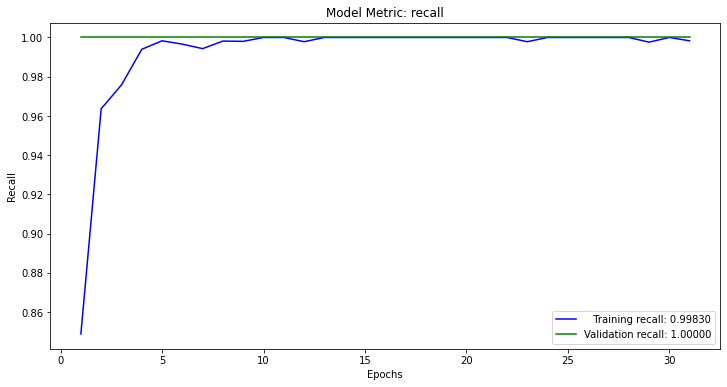

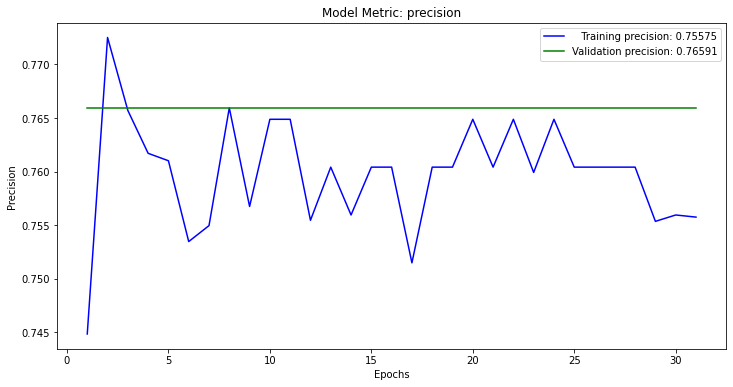

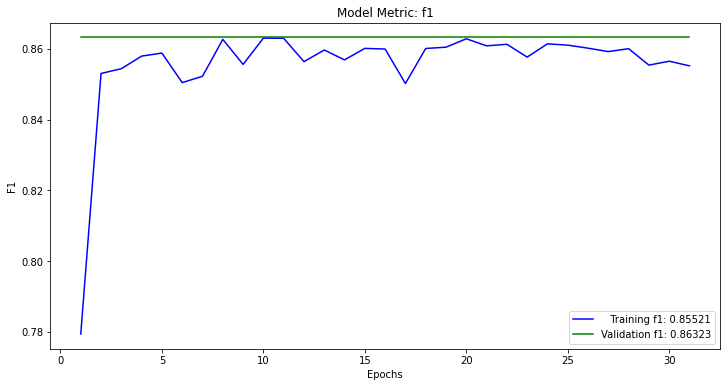

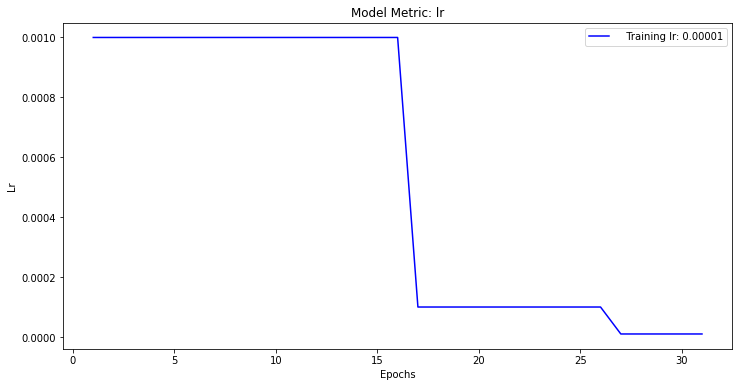

6/6 [==============================] - 0s 4ms/step - loss: 0.5477 - acc: 0.7636 - recall: 1.0000 - precision: 0.7688 - f1: 0.8674

--------------------------------------------------


Binary Crossentropy for model: 54.766 %

Accuracy for model: 76.364 %

Recall for model: 100.000 %

Precision for model: 76.875 %

F1 for model: 86.738 %

--------------------------------------------------


--------------------------------------------------

Fitting Random Forests CLF

--------------------------------------------------

Fitting Logistic Regression CLF

--------------------------------------------------



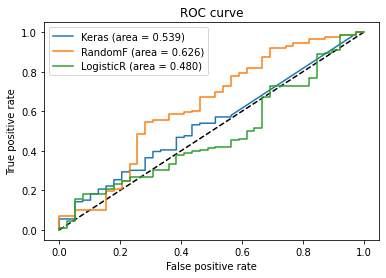


--------------------------------------------------

Study probability: 67.606 %


1

In [47]:
# Define Keras Callbacks

keras_callbacks = [ 
             EarlyStopping( 
                 monitor = 'val_loss', 
                 min_delta = 0.0001,
                 mode='min',
                 patience = 25, 
                 restore_best_weights = True,
                 verbose = 1, 
                 ), 

             ModelCheckpoint( 
                 filepath='pretrained_mlp_nadam_h5', 
                 monitor='val_loss', 
                 mode='min',
                 save_best_only = True, 
                 save_weights_only = False,
                 verbose = 1 
                 ), 

             ReduceLROnPlateau( 
                 monitor = 'val_loss', 
                 factor = 0.1, 
                 patience = 10, 
                 verbose = 1 
                 ) 
             ]

# Define The Neural Network Model

# Define an empty sequential structure
pretrained_mlp_nadam_model = Sequential()

# Pre-Trained Embedding Layer
pretrained_mlp_nadam_model.add(Embedding(
    input_dim = max_words, 
    output_dim = pre_embedding_dim , 
    input_length = maxlen, 
    weights=[embedding_matrix], 
    trainable = False
    )
)

pretrained_mlp_nadam_model.add(Flatten())

# Input layer
pretrained_mlp_nadam_model.add(Dense(32, input_dim=x_train.shape[1]))
pretrained_mlp_nadam_model.add(Activation('relu'))
pretrained_mlp_nadam_model.add(Dropout(0.5))

# Hidden layer    
pretrained_mlp_nadam_model.add(Dense(64))
pretrained_mlp_nadam_model.add(Activation('relu'))
pretrained_mlp_nadam_model.add(Dropout(0.5))

# Hidden layer    
pretrained_mlp_nadam_model.add(Dense(64))
pretrained_mlp_nadam_model.add(Activation('relu'))
pretrained_mlp_nadam_model.add(Dropout(0.5))

# Output Layer
pretrained_mlp_nadam_model.add(Dense(1,  activation = 'sigmoid'))

add_space()
pretrained_mlp_nadam_model.summary()

add_space()
plot_model(
    pretrained_mlp_nadam_model, 
    to_file='pretrained_mlp_nadam_model_plot.png', 
    show_shapes=True, 
    show_layer_names=True
    )

add_space()
print('Compiling Model..')

# Compile model
pretrained_mlp_nadam_model.compile(
    loss='binary_crossentropy', 
    optimizer='nadam', 
    metrics=['acc', recall, precision, f1]
    )

add_space()
print('Fitting Model..')
# Model Fit
history_pretrained_mlp_nadam_model = pretrained_mlp_nadam_model.fit(
    x_train, y_train, epochs=250, batch_size=16, 
    validation_data=(x_val, y_val), verbose = 1, 
    callbacks= keras_callbacks, shuffle = True 
    )

add_space()
pprint(history_pretrained_mlp_nadam_model.history)

add_space()
plot_keras_history(history_pretrained_mlp_nadam_model)

# Model Evaluation
score_pretrained_mlp_nadam_model = pretrained_mlp_nadam_model.evaluate( 
    x_val, y_val, 
    batch_size=32, 
    verbose=1
    )

add_space()
print('\nBinary Crossentropy for model: {:.3f} %'.format(score_pretrained_mlp_nadam_model[0]*100))
print('\nAccuracy for model: {:.3f} %'.format(score_pretrained_mlp_nadam_model[1]*100))
print('\nRecall for model: {:.3f} %'.format(score_pretrained_mlp_nadam_model[2]*100))
print('\nPrecision for model: {:.3f} %'.format(score_pretrained_mlp_nadam_model[3]*100))
print('\nF1 for model: {:.3f} %'.format(score_pretrained_mlp_nadam_model[4]*100))


add_space()
# Model Prediction
y_pred_keras = pretrained_mlp_nadam_model.predict(x_val).ravel()
add_space()

print('Fitting Random Forests CLF')
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=50)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict_proba(x_val)[:, 1]

add_space()
print('Fitting Logistic Regression CLF')
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred_lr = lr.predict_proba(x_val)[:, 1]

add_space()
plot_binary_class_row_auc(
    y_true=y_val, 
    clf_names=['Keras', 'RandomF', 'LogisticR'], 
    clfs_preds=[y_pred_keras, y_pred_rf, y_pred_lr])

pretrained_mlp_nadam_model_text = 'A novel renewable energy selection model for United Nations sustainable development goals' \
'In 2015, the United Nations announced the new Sustainable Development Goals (SDGs) to safeguard the earth and end poverty as the new global sustainable development agenda.' \
'One of these SDGs, Goal #7, is about affordable and clean energy.' \
'Despite the importance, there are few tools that guide policy-makers in aligning their domestic policies with these SDGs.' \
'The paper addresses this research gap and introduces a numerical decision-support method for identifying the most suitable renewable energy source (RES).' \
'RES selection according to SDGs can be a challenge for decision makers.' \
'This article presents an integrated multi-criteria decision-making (MCDM) method that is based on hesitant fuzzy linguistic (HFL) term set.' \
'The decision criteria are weighed with HFL Analytic Hierarchy Process (AHP), and the most appropriate RES alternative is chosen with the HFL COmplex PRoportional ASsessment (COPRAS) technique.' \
'The value of the method is demonstrated on a case from Turkey, and a comparative analysis.' \
'This approach constitutes a novelty by proposing a numerical model for SDGs that combines AHP and COPRAS in a HFL environment with group decision-making for the first time.' \
'The method can help policy-makers in better structuring local energy policies with regard to global efforts in a developing country setting.' \

add_space()
predict_new_comment(
    text=pretrained_mlp_nadam_model_text, 
    tokenizer=tokenizer, 
    seq_max_length=maxlen, 
    model=pretrained_mlp_nadam_model
    )

## Model 2
- Hidden Layers: 3
- Neurons: 64, 128
- Dropout: 0.5
- BatchNormalization
- Optimizer: Adam


--------------------------------------------------

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 100)          500000    
_________________________________________________________________
flatten_4 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                1280064   
_________________________________________________________________
batch_normalization_22 (Batc (None, 64)                256       
_________________________________________________________________
activation_27 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 64)                0         
_________________________________________________________________
d

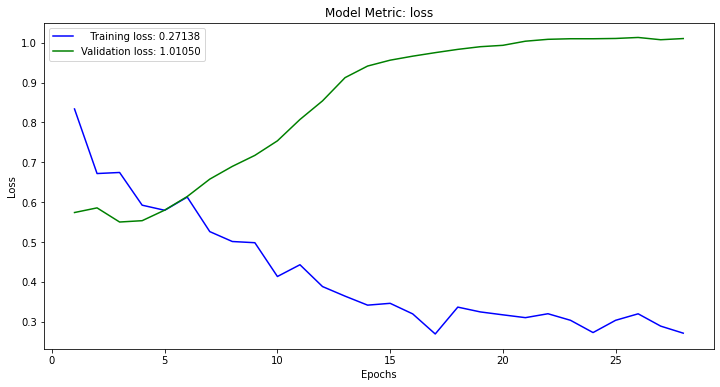

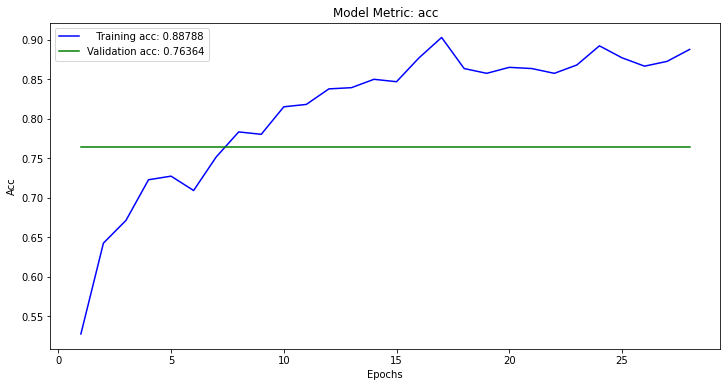

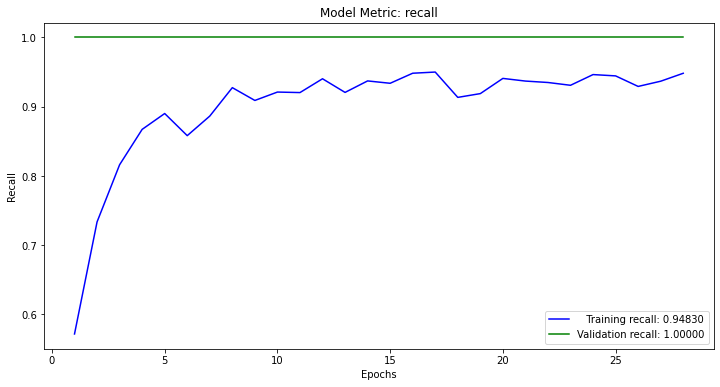

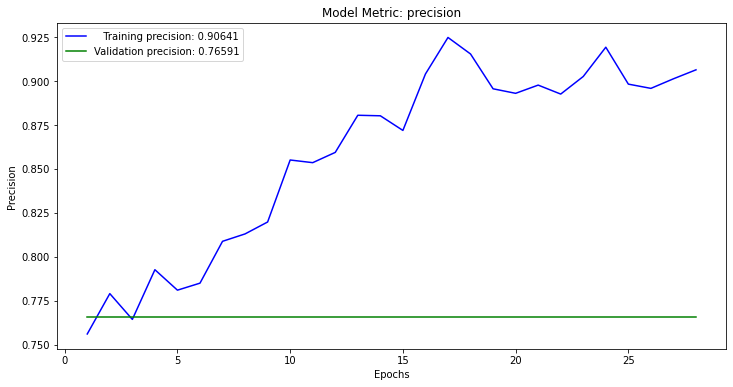

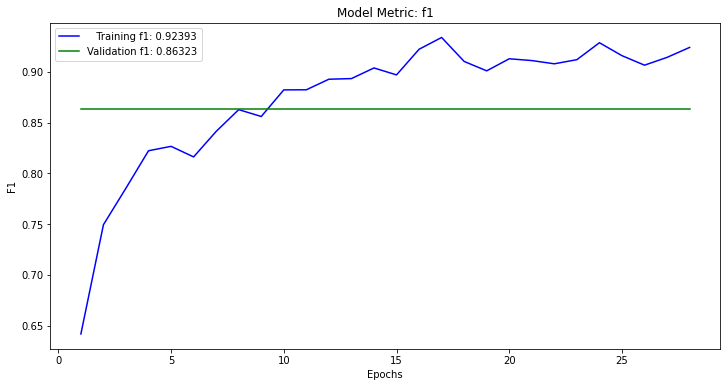

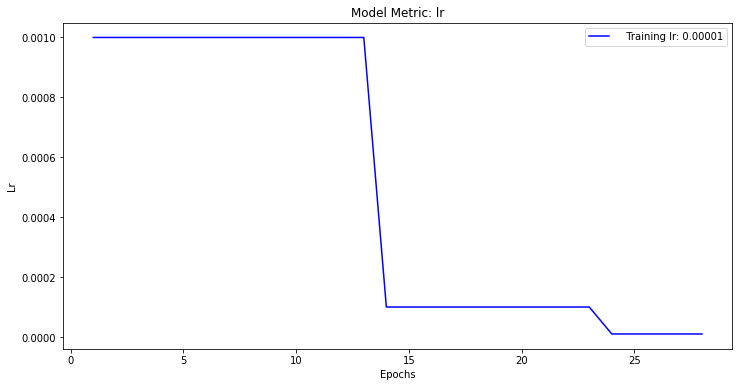

6/6 [==============================] - 0s 4ms/step - loss: 0.5502 - acc: 0.7636 - recall: 1.0000 - precision: 0.7688 - f1: 0.8674

--------------------------------------------------


Binary Crossentropy for model: 55.022 %

Accuracy for model: 76.364 %

Recall for model: 100.000 %

Precision for model: 76.875 %

F1 for model: 86.738 %

--------------------------------------------------


--------------------------------------------------

Fitting Random Forests CLF

--------------------------------------------------

Fitting Logistic Regression CLF

--------------------------------------------------



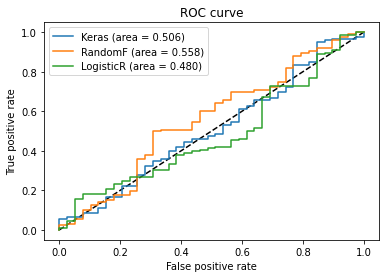


--------------------------------------------------

Study probability: 66.558 %


1

In [48]:
# Define Keras Callbacks

keras_callbacks = [ 
             EarlyStopping( 
                 monitor = 'val_loss', 
                 min_delta = 0.0001,
                 mode='min',
                 patience = 25, 
                 restore_best_weights = True,
                 verbose = 1, 
                 ), 

             ModelCheckpoint( 
                 filepath='pretrained_mlp_adam_h5', 
                 monitor='val_loss', 
                 mode='min',
                 save_best_only = True, 
                 save_weights_only = False,
                 verbose = 1 
                 ), 

             ReduceLROnPlateau( 
                 monitor = 'val_loss', 
                 factor = 0.1, 
                 patience = 10, 
                 verbose = 1 
                 ) 
             ]

# Define The Neural Network Model

# define an empty sequential structure
pretrained_mlp_adam_model = Sequential()

# Pre-Trained Embedding Layer
pretrained_mlp_adam_model.add(Embedding(
    input_dim = max_words, 
    output_dim = pre_embedding_dim , 
    input_length = maxlen, 
    weights=[embedding_matrix], 
    trainable = False
    )
)

pretrained_mlp_adam_model.add(Flatten())

# Input layer
pretrained_mlp_adam_model.add(Dense(64, input_dim=x_train.shape[1]))
pretrained_mlp_adam_model.add(BatchNormalization())
pretrained_mlp_adam_model.add(Activation('relu'))
pretrained_mlp_adam_model.add(Dropout(0.5))

# Hidden layer    
pretrained_mlp_adam_model.add(Dense(128))
pretrained_mlp_adam_model.add(BatchNormalization())
pretrained_mlp_adam_model.add(Activation('relu'))
pretrained_mlp_adam_model.add(Dropout(0.5))

# Hidden layer    
pretrained_mlp_adam_model.add(Dense(128))
pretrained_mlp_adam_model.add(BatchNormalization())
pretrained_mlp_adam_model.add(Activation('relu'))
pretrained_mlp_adam_model.add(Dropout(0.5))

# Hidden layer    
pretrained_mlp_adam_model.add(Dense(128))
pretrained_mlp_adam_model.add(BatchNormalization())
pretrained_mlp_adam_model.add(Activation('relu'))
pretrained_mlp_adam_model.add(Dropout(0.5))

# Output Layer
pretrained_mlp_adam_model.add(BatchNormalization())
# pretrained_mlp_adam_model.add(Dropout(0.5))
pretrained_mlp_adam_model.add(Dense(1,  activation = 'sigmoid'))

add_space()
pretrained_mlp_adam_model.summary()

add_space()
plot_model(
    pretrained_mlp_adam_model, 
    to_file='pretrained_mlp_adam_model_plot.png', 
    show_shapes=True, 
    show_layer_names=True
    )

add_space()
print('Compiling Model..')

# Compile model
pretrained_mlp_adam_model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['acc', recall, precision, f1]
    )

add_space()
print('Fitting Model..')
# Model Fit
history_pretrained_mlp_adam_model = pretrained_mlp_adam_model.fit(
    x_train, y_train, 
    epochs=250, batch_size=16, 
    validation_data=(x_val, y_val), 
    verbose = 1, callbacks= keras_callbacks, shuffle = True 
    )

add_space()
pprint(history_pretrained_mlp_adam_model.history)

add_space()
plot_keras_history(history_pretrained_mlp_adam_model)

# Model Evaluation
score_pretrained_mlp_adam_model = pretrained_mlp_adam_model.evaluate( 
    x_val, y_val, 
    batch_size=32, 
    verbose=1
    )

add_space()
print('\nBinary Crossentropy for model: {:.3f} %'.format(score_pretrained_mlp_adam_model[0]*100))
print('\nAccuracy for model: {:.3f} %'.format(score_pretrained_mlp_adam_model[1]*100))
print('\nRecall for model: {:.3f} %'.format(score_pretrained_mlp_adam_model[2]*100))
print('\nPrecision for model: {:.3f} %'.format(score_pretrained_mlp_adam_model[3]*100))
print('\nF1 for model: {:.3f} %'.format(score_pretrained_mlp_adam_model[4]*100))


add_space()
# Model Prediction
y_pred_keras = pretrained_mlp_adam_model.predict(x_val).ravel()
add_space()

print('Fitting Random Forests CLF')
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=50)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict_proba(x_val)[:, 1]

add_space()
print('Fitting Logistic Regression CLF')
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred_lr = lr.predict_proba(x_val)[:, 1]

add_space()
plot_binary_class_row_auc(
    y_true=y_val, 
    clf_names=['Keras', 'RandomF', 'LogisticR'], 
    clfs_preds=[y_pred_keras, y_pred_rf, y_pred_lr])

pretrained_mlp_adam_model_text = 'A comprehensive indicator set for measuring multiple benefits of energy efficiency' \
'In this paper, we develop a quantitative indicator approach including 20 indicators to measure the multiple benefits of energy efficiency (MB-EE).' \
'The MB-EEs are classified into three groups: environmental (e.g.' \
'energy savings, emissions), economic (e.g.' \
'GDP, employment), and social (health, energy poverty) aspects.' \
'We explain the methodological approach, the underlying data sources and limitations.' \
'The indicator set has been applied to 29 countries (EU28 plus Norway) for the period 2000 to 2015, proving that it allows to conduct in-depth comparisons of developments and differences across Europe.' \
'The indicator set also supports the design of well-suited energy policies by allowing to take into account, on an informed basis, more of the multiple impacts of energy efficiency.' \
'For example, our analysis of the effect of energy savings for the period 2000 to 2015 in Germany shows GHG savings of about 158 MtCO2eq., about 30,000 avoided deaths due to less air pollution, a reduction of Germanys import dependency by 5.8 percentage points and a growth of GDP by around 0.3% per year for the period 2010 to 2015) as a consequence of improved energy efficiency.' \
'To conclude, the presented approach allows to comprehensively and regularly assess policies in terms of their MB-EEs.' \

add_space()
predict_new_comment(
    text=pretrained_mlp_adam_model_text, 
    tokenizer=tokenizer, 
    seq_max_length=maxlen, 
    model=pretrained_mlp_adam_model
    )

## Model 3
- Hidden Layers: 4
- Neurons: 128, 256
- Dropout: 0.5
- BatchNormalization
- Optimizer: SGD


--------------------------------------------------

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 100)          500000    
_________________________________________________________________
flatten_5 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_39 (Dense)             (None, 128)               2560128   
_________________________________________________________________
batch_normalization_27 (Batc (None, 128)               512       
_________________________________________________________________
activation_31 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 128)               0         
_________________________________________________________________
d

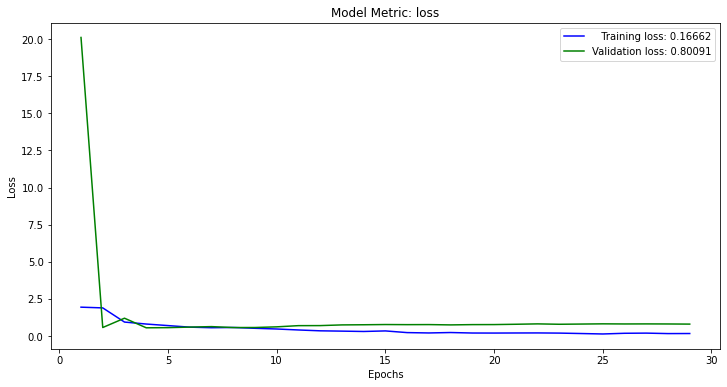

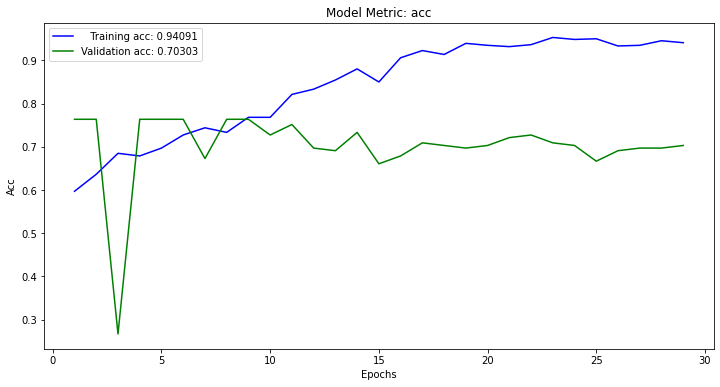

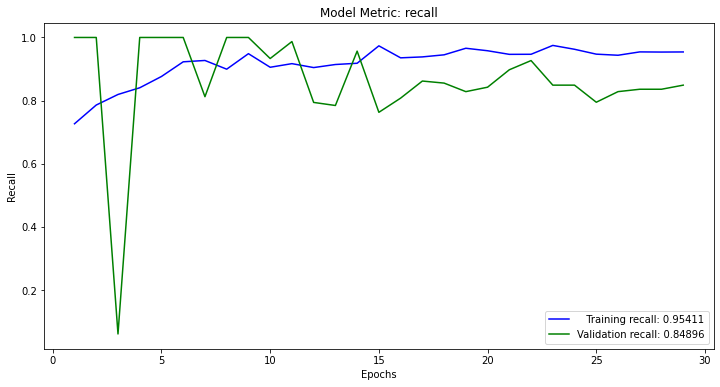

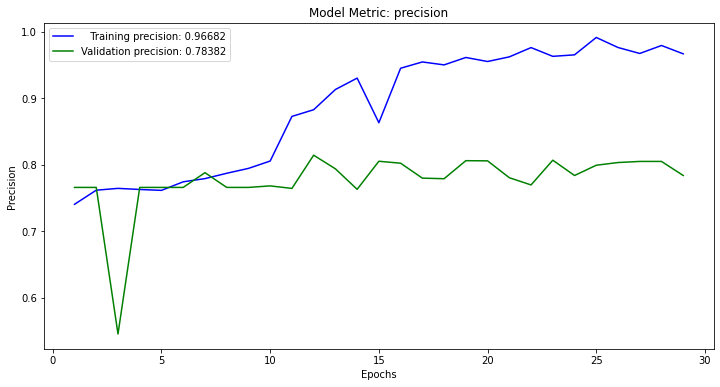

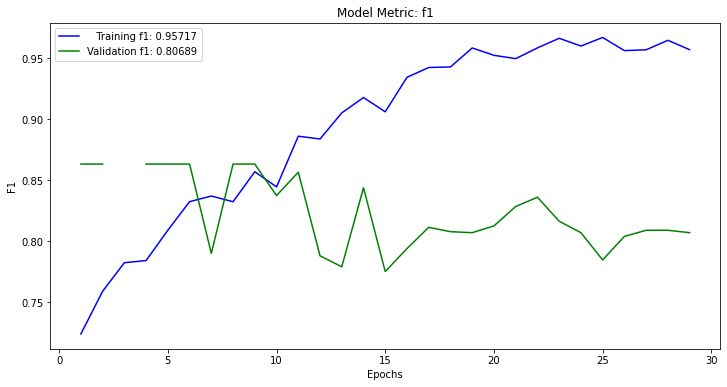

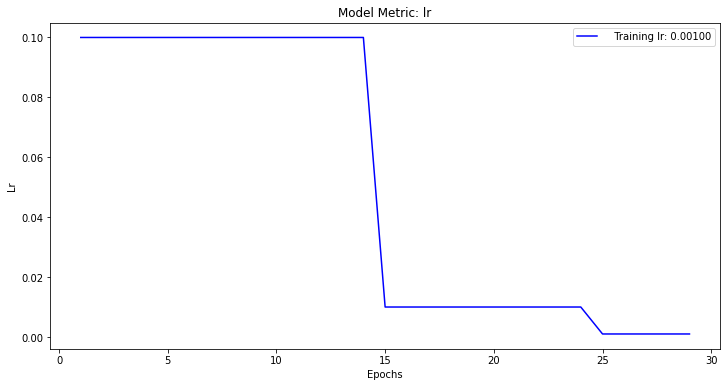

6/6 [==============================] - 0s 4ms/step - loss: 0.5520 - acc: 0.7636 - recall: 1.0000 - precision: 0.7688 - f1: 0.8674

--------------------------------------------------


Binary Crossentropy for model: 55.203 %

Accuracy for model: 76.364 %

Recall for model: 100.000 %

Precision for model: 76.875 %

F1 for model: 86.738 %

--------------------------------------------------


--------------------------------------------------

Fitting Random Forests CLF

--------------------------------------------------

Fitting Logistic Regression CLF

--------------------------------------------------



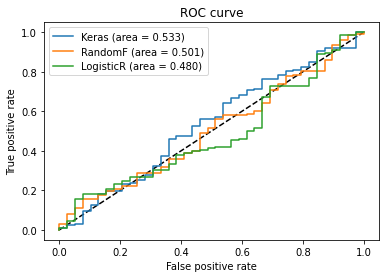


--------------------------------------------------

Study probability: 75.356 %


1

In [49]:
# Define Keras Callbacks

keras_callbacks = [ 
             EarlyStopping( 
                 monitor = 'val_loss', 
                 min_delta = 0.0001,
                 mode='min',
                 patience = 25, 
                 restore_best_weights = True,
                 verbose = 1, 
                 ), 

             ModelCheckpoint( 
                 filepath='pretrained_mlp_deep_sgd_h5', 
                 monitor='val_loss', 
                 mode='min',
                 save_best_only = True, 
                 save_weights_only = False,
                 verbose = 1 
                 ), 

             ReduceLROnPlateau( 
                 monitor = 'val_loss', 
                 factor = 0.1, 
                 patience = 10, 
                 verbose = 1 
                 ) 
             ]

# Define The Neural Network Model

# define an empty sequential structure
pretrained_mlp_deep_sgd_model = Sequential()

# Pre-Trained Embedding Layer
pretrained_mlp_deep_sgd_model.add(Embedding(
    input_dim = max_words, 
    output_dim = pre_embedding_dim , 
    input_length = maxlen, 
    weights=[embedding_matrix], 
    trainable = False
    )
)

pretrained_mlp_deep_sgd_model.add(Flatten())

# Input layer
pretrained_mlp_deep_sgd_model.add(Dense(128, input_dim=x_train.shape[1]))
pretrained_mlp_deep_sgd_model.add(BatchNormalization())
pretrained_mlp_deep_sgd_model.add(Activation('relu'))
pretrained_mlp_deep_sgd_model.add(Dropout(0.5))

# Hidden layer    
pretrained_mlp_deep_sgd_model.add(Dense(256))
pretrained_mlp_adam_model.add(BatchNormalization())
pretrained_mlp_deep_sgd_model.add(Activation('relu'))
pretrained_mlp_deep_sgd_model.add(Dropout(0.5))

# Hidden layer    
pretrained_mlp_deep_sgd_model.add(Dense(256))
pretrained_mlp_adam_model.add(BatchNormalization())
pretrained_mlp_deep_sgd_model.add(Activation('relu'))
pretrained_mlp_deep_sgd_model.add(Dropout(0.5))

# Hidden layer    
pretrained_mlp_deep_sgd_model.add(Dense(256))
pretrained_mlp_adam_model.add(BatchNormalization())
pretrained_mlp_deep_sgd_model.add(Activation('relu'))
pretrained_mlp_deep_sgd_model.add(Dropout(0.5))

# Hidden layer    
pretrained_mlp_deep_sgd_model.add(Dense(256))
pretrained_mlp_adam_model.add(BatchNormalization())
pretrained_mlp_deep_sgd_model.add(Activation('relu'))
pretrained_mlp_deep_sgd_model.add(Dropout(0.5))

# Output Layer
pretrained_mlp_deep_sgd_model.add(BatchNormalization())
pretrained_mlp_deep_sgd_model.add(Dropout(0.5))
pretrained_mlp_deep_sgd_model.add(Dense(1,  activation = 'sigmoid'))

add_space()
pretrained_mlp_deep_sgd_model.summary()

add_space()
plot_model(
    pretrained_mlp_deep_sgd_model, 
    to_file='pretrained_mlp_deep_sgd_model_plot.png', 
    show_shapes=True, 
    show_layer_names=True
    )

add_space()
print('Compiling Model..')

# Setting up the optimization of our weights 
sgd = SGD(lr=0.1,
          decay=1e-6,
          momentum=0.9,
          nesterov=True)

# Compile model
pretrained_mlp_deep_sgd_model.compile(
    loss='binary_crossentropy', 
    optimizer=sgd, 
    metrics=['acc', recall, precision, f1]
    )

add_space()
print('Fitting Model..')
# Model Fit
history_pretrained_mlp_deep_sgd_model = pretrained_mlp_deep_sgd_model.fit(
    x_train, y_train, 
    epochs=250, batch_size=16, 
    validation_data=(x_val, y_val), 
    verbose = 1, callbacks= keras_callbacks, shuffle = True 
    )

add_space()
pprint(history_pretrained_mlp_deep_sgd_model.history)

add_space()
plot_keras_history(history_pretrained_mlp_deep_sgd_model)

# Model Evaluation
score_pretrained_mlp_deep_sgd_model = pretrained_mlp_deep_sgd_model.evaluate( 
    x_val, y_val, 
    batch_size=32, 
    verbose=1
    )

add_space()
print('\nBinary Crossentropy for model: {:.3f} %'.format(score_pretrained_mlp_deep_sgd_model[0]*100))
print('\nAccuracy for model: {:.3f} %'.format(score_pretrained_mlp_deep_sgd_model[1]*100))
print('\nRecall for model: {:.3f} %'.format(score_pretrained_mlp_deep_sgd_model[2]*100))
print('\nPrecision for model: {:.3f} %'.format(score_pretrained_mlp_deep_sgd_model[3]*100))
print('\nF1 for model: {:.3f} %'.format(score_pretrained_mlp_deep_sgd_model[4]*100))


add_space()
# Model Prediction
y_pred_keras = pretrained_mlp_deep_sgd_model.predict(x_val).ravel()
add_space()

print('Fitting Random Forests CLF')
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=50)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict_proba(x_val)[:, 1]

add_space()
print('Fitting Logistic Regression CLF')
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred_lr = lr.predict_proba(x_val)[:, 1]

add_space()
plot_binary_class_row_auc(
    y_true=y_val, 
    clf_names=['Keras', 'RandomF', 'LogisticR'], 
    clfs_preds=[y_pred_keras, y_pred_rf, y_pred_lr])

pretrained_mlp_deep_sgd_model_text = 'The energy metabolism of countries: Energy efficiency and use in the period that followed the global financial crisis' \
'This paper discusses how the deceleration of economic growth, that followed the financial crisis of 2008, influenced the energy efficiency, allocation and use of 18 European countries.' \
'By using a Multi-scale Integrated Analysis of Societal and Ecosystem Metabolism (MuSIASEM), the relationships between energy requirements, economic trends and population are investigated for the years 2008 and 2015.' \
'The analyses are performed for the entire society (Level N), for the household and the paid sectors (Level N-1) and for the agricultural, the industrial and the service activities (Level N-2).' \
'Results show that two main groups of countries performed the largest energy reductions, namely: the country most affected by the global financial crisis, such as Greece, Romania and Spain, where the total energy throughput decreased by âˆ’19.6%, âˆ’15.8% and âˆ’12.1%, respectively; and the countries, such as Ireland and United Kingdom, that experienced the largest energy intensity reductions (âˆ’38.7% and âˆ’19.2%), together with the highest GDP increases (+44.8% and +10.2%).' \
'By providing an overview of the relationships existing between socio-economic and energy variables, this paper contributes to the debate around growth and efficiency and can support the design of policies oriented to promote the achievement of a more sustainable and competitive economy.' \

add_space()
predict_new_comment(
    text=pretrained_mlp_deep_sgd_model_text, 
    tokenizer=tokenizer, 
    seq_max_length=maxlen, 
    model=pretrained_mlp_deep_sgd_model
    )

---

# CNN - Self-trained Embeddings


--------------------------------------------------

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 50)           250000    
_________________________________________________________________
conv1d (Conv1D)              (None, 198, 32)           4832      
_________________________________________________________________
batch_normalization_33 (Batc (None, 198, 32)           128       
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 32)                0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 32)                128       
_________________________________________________________________
d

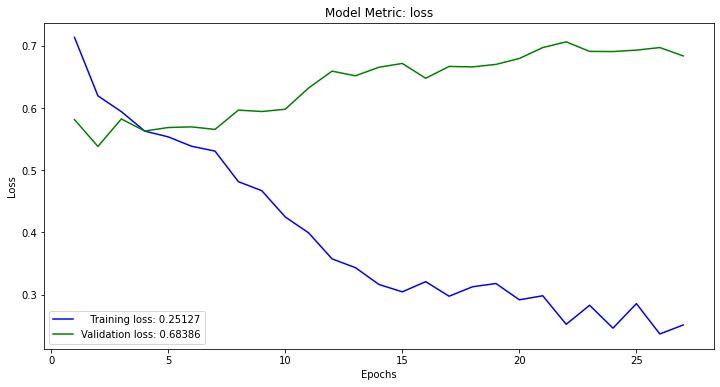

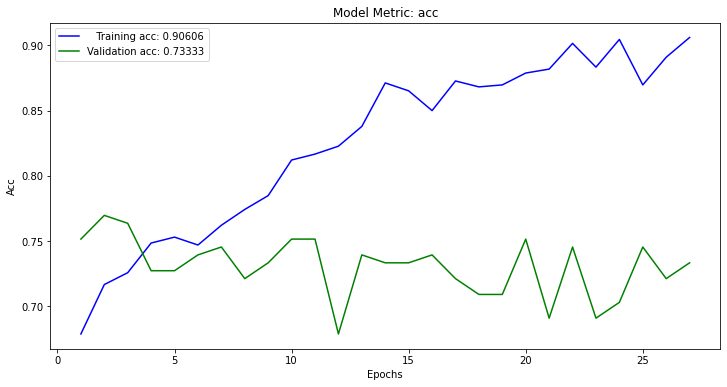

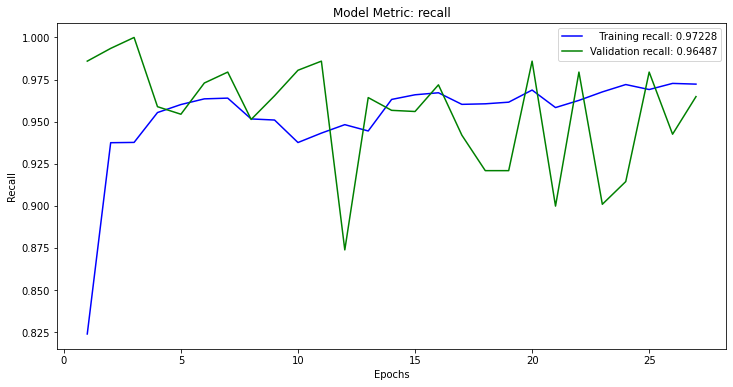

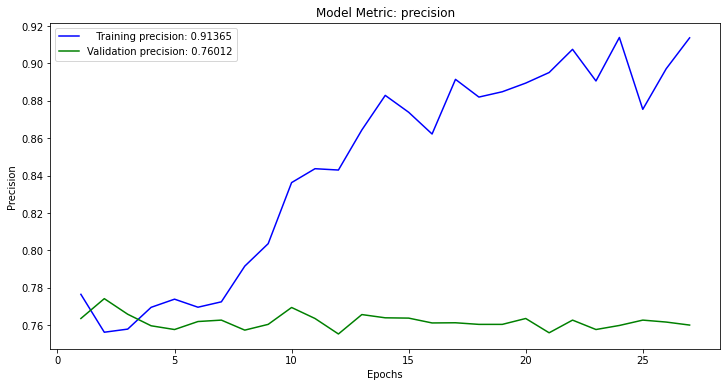

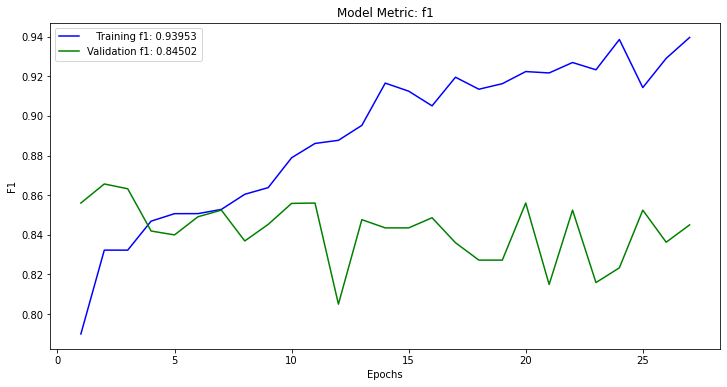

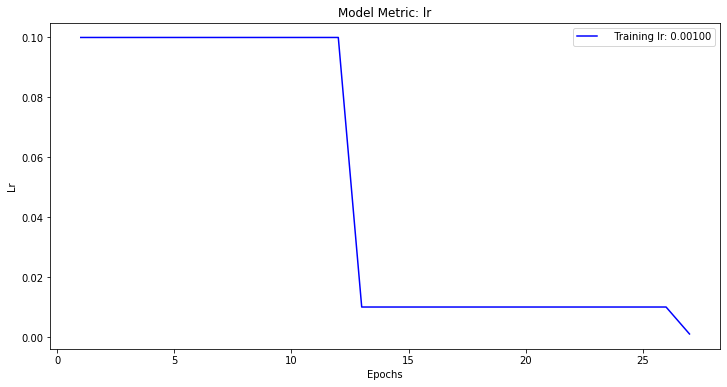

6/6 [==============================] - 0s 4ms/step - loss: 0.5383 - acc: 0.7697 - recall: 0.9938 - precision: 0.7762 - f1: 0.8696

--------------------------------------------------


Binary Crossentropy for model: 53.830 %

Accuracy for model: 76.970 %

Recall for model: 99.383 %

Precision for model: 77.624 %

F1 for model: 86.955 %

--------------------------------------------------


--------------------------------------------------

Fitting Random Forests CLF

--------------------------------------------------

Fitting Logistic Regression CLF

--------------------------------------------------



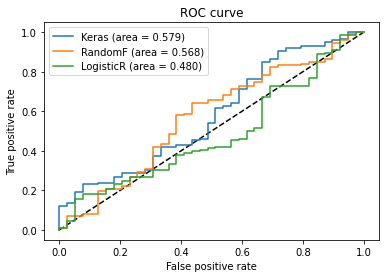


--------------------------------------------------

Study probability: 87.006 %


1

In [50]:
# Define Keras Callbacks

keras_callbacks = [ 
             EarlyStopping( 
                 monitor = 'val_loss', 
                 min_delta = 0.0001,
                 mode='min',
                 patience = 25, 
                 restore_best_weights = True,
                 verbose = 1, 
                 ), 

             ModelCheckpoint( 
                 filepath='selfembed_cnn_sgd_h5', 
                 monitor='val_loss', 
                 mode='min',
                 save_best_only = True, 
                 save_weights_only = False,
                 verbose = 1 
                 ), 

             ReduceLROnPlateau( 
                 monitor = 'val_loss', 
                 factor = 0.1, 
                 cooldown = 5,
                 patience = 10, 
                 verbose = 1 
                 ) 
             ]

# Define The Neural Network Model
# Create a Baseline Neural Network

selfembed_cnn_sgd_model = Sequential()

# Embedding layer
selfembed_cnn_sgd_model.add(Embedding( 
    input_dim = max_words, 
    output_dim = self_embedding_dim , 
    embeddings_initializer = 'uniform', 
    trainable = True,
    mask_zero = True, 
    input_length = maxlen
    )
)

selfembed_cnn_sgd_model.add(Conv1D(32, 3, padding='valid', activation='relu', strides=1))
selfembed_cnn_sgd_model.add(BatchNormalization(momentum=0.9))
selfembed_cnn_sgd_model.add(GlobalMaxPooling1D())

selfembed_cnn_sgd_model.add(Flatten())

pretrained_mlp_deep_sgd_model.add(Dense(64))
pretrained_mlp_adam_model.add(BatchNormalization(momentum=0.9))
pretrained_mlp_deep_sgd_model.add(Activation('relu'))
pretrained_mlp_deep_sgd_model.add(Dropout(0.5))

selfembed_cnn_sgd_model.add(BatchNormalization(momentum=0.9))
selfembed_cnn_sgd_model.add(Dropout(0.5))
selfembed_cnn_sgd_model.add(Dense(1,  activation = 'sigmoid'))

add_space()
selfembed_cnn_sgd_model.summary()

add_space()
plot_model(
    selfembed_cnn_sgd_model, 
    to_file='selfembed_cnn_sgd_model_plot.png', 
    show_shapes=True, 
    show_layer_names=True
    )

add_space()
print('Compiling Model..')

# Setting up the optimization of our weights 
epochs = 25
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, 
          decay=decay_rate, 
          momentum=momentum, 
          nesterov=False
          )

# Compile model
selfembed_cnn_sgd_model.compile(
    loss='binary_crossentropy', 
    optimizer=sgd, 
    metrics=['acc', recall, precision, f1]
    )

add_space()
print('Fitting Model..')
# Model Fit
history_selfembed_cnn_sgd_model = selfembed_cnn_sgd_model.fit(
    x_train, y_train, 
    epochs=250, batch_size=16, 
    validation_data=(x_val, y_val), 
    verbose = 1, callbacks= keras_callbacks, shuffle = True 
    )

add_space()
pprint(history_selfembed_cnn_sgd_model.history)

add_space()
plot_keras_history(history_selfembed_cnn_sgd_model)

# Model Evaluation
score_selfembed_cnn_sgd_model = selfembed_cnn_sgd_model.evaluate( 
    x_val, y_val, 
    batch_size=32, 
    verbose=1
    )

add_space()
print('\nBinary Crossentropy for model: {:.3f} %'.format(score_selfembed_cnn_sgd_model[0]*100))
print('\nAccuracy for model: {:.3f} %'.format(score_selfembed_cnn_sgd_model[1]*100))
print('\nRecall for model: {:.3f} %'.format(score_selfembed_cnn_sgd_model[2]*100))
print('\nPrecision for model: {:.3f} %'.format(score_selfembed_cnn_sgd_model[3]*100))
print('\nF1 for model: {:.3f} %'.format(score_selfembed_cnn_sgd_model[4]*100))


add_space()
# Model Prediction
y_pred_keras = selfembed_cnn_sgd_model.predict(x_val).ravel()
add_space()

print('Fitting Random Forests CLF')
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=50)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict_proba(x_val)[:, 1]

add_space()
print('Fitting Logistic Regression CLF')
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred_lr = lr.predict_proba(x_val)[:, 1]

add_space()
plot_binary_class_row_auc(
    y_true=y_val, 
    clf_names=['Keras', 'RandomF', 'LogisticR'], 
    clfs_preds=[y_pred_keras, y_pred_rf, y_pred_lr])

selfembed_cnn_sgd_model_text = 'Asymmetric and extreme influence of energy price changes on renewable energy stock performance' \
'Promoting the development of renewable energy has become the key factor to solve the problems of energy and climate change issues.' \
'However, its development is largely constrained by the prices of traditional fossil energy.' \
'This paper explores the influence of various fossil energy price changes on renewable energy stock returns using a network approach.' \
'Specifically, a positive and negative returns network and value-at-risk (VaR) network are constructed separately for identifying the asymmetric and extreme information spillover.' \
'Our findings show the fossil energyâ€“renewable energy network system has a relatively high level of interdependence.' \
'The electricity market behaves as the major contributor to the changes of renewable energy returns in the returns connectedness network, while oil and coal contribute most to the changes of renewable energy returns in the VaR connectedness network.' \
'The dynamic results show that the contributions of fossil energy price changes to renewable energy returns have strong time-varying pattern with high volatility over time.' \
'The total connectedness in the positive returns network is slightly stronger than that in the negative returns network for most of the time during our sample period.' \

add_space()
predict_new_comment(
    text=selfembed_cnn_sgd_model_text, 
    tokenizer=tokenizer, 
    seq_max_length=maxlen, 
    model=selfembed_cnn_sgd_model
    )

# CNN - Pre-trained GloVe Embeddings


--------------------------------------------------

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 100)          500000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 198, 128)          38528     
_________________________________________________________________
batch_normalization_36 (Batc (None, 198, 128)          512       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 128)               0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 128)               512       
_________________________________________________________________


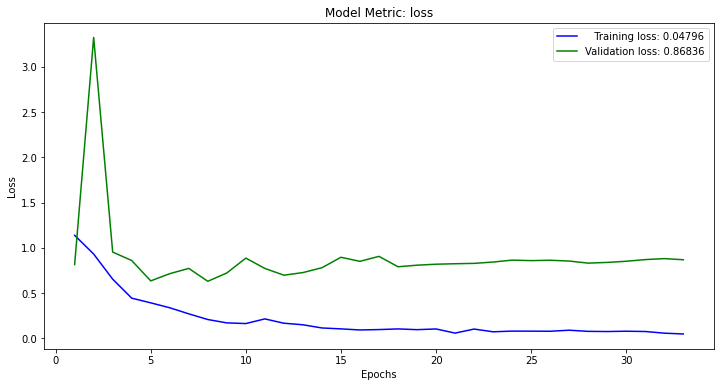

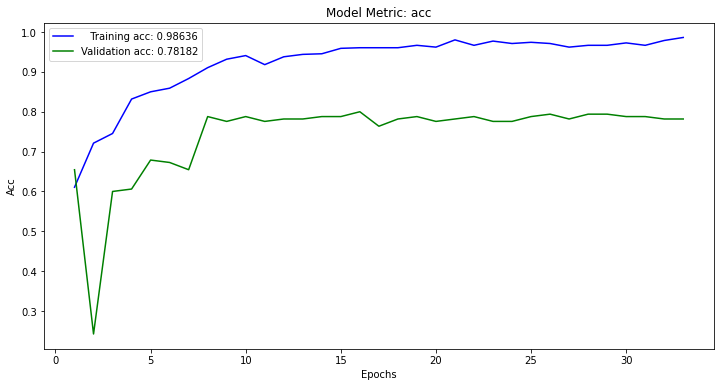

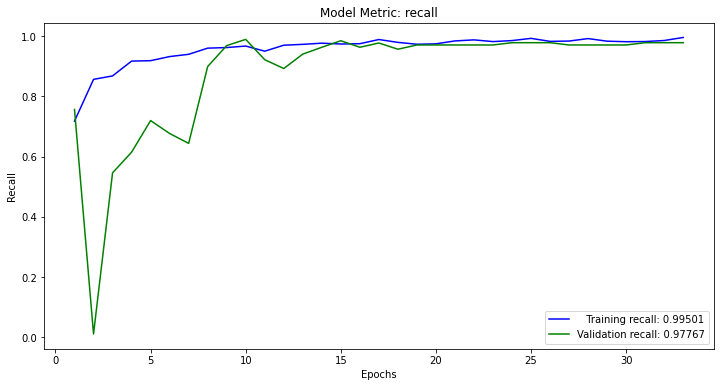

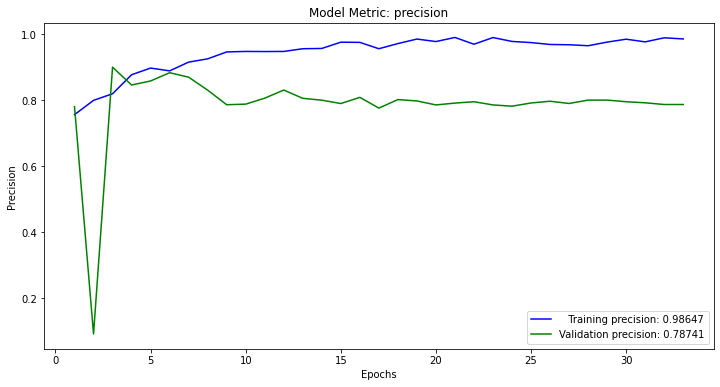

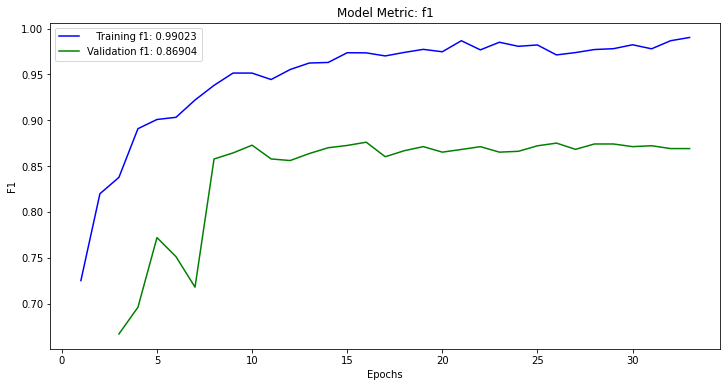

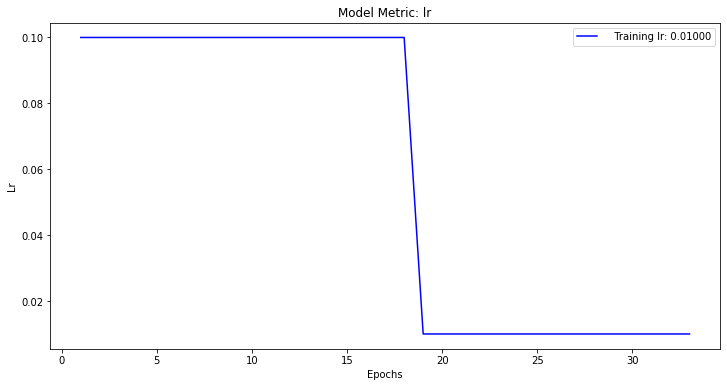

6/6 [==============================] - 0s 5ms/step - loss: 0.6303 - acc: 0.7879 - recall: 0.9103 - precision: 0.8323 - f1: 0.8667

--------------------------------------------------


Binary Crossentropy for model: 63.027 %

Accuracy for model: 78.788 %

Recall for model: 91.033 %

Precision for model: 83.229 %

F1 for model: 86.671 %

--------------------------------------------------


--------------------------------------------------

Fitting Random Forests CLF

--------------------------------------------------

Fitting Logistic Regression CLF

--------------------------------------------------



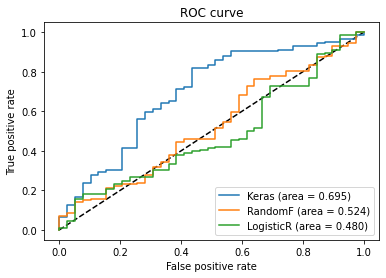


--------------------------------------------------

Study probability: 64.664 %


1

In [51]:
# Define Keras Callbacks

keras_callbacks = [ 
             EarlyStopping( 
                 monitor = 'val_loss', 
                 min_delta = 0.0001,
                 mode='min',
                 patience = 25, 
                 restore_best_weights = True,
                 verbose = 1, 
                 ), 

             ModelCheckpoint( 
                 filepath='pretrainedembed_cnn_sgd_h5', 
                 monitor='val_loss', 
                 mode='min',
                 save_best_only = True, 
                 save_weights_only = False,
                 verbose = 1 
                 ), 

             ReduceLROnPlateau( 
                 monitor = 'val_loss', 
                 factor = 0.1, 
                 cooldown = 10,
                 patience = 10, 
                 verbose = 1 
                 ) 
             ]

# Define The Neural Network Model
# Create a Baseline Neural Network

pretrainedembed_cnn_sgd_model = Sequential()

# Pre-Trained Embedding Layer
pretrainedembed_cnn_sgd_model.add(Embedding(
    input_dim = max_words, 
    output_dim = pre_embedding_dim , 
    input_length = maxlen, 
    weights=[embedding_matrix], 
    trainable = False
    )
)

pretrainedembed_cnn_sgd_model.add(Conv1D(128, 3, padding='valid', activation='relu', strides=1))
pretrainedembed_cnn_sgd_model.add(BatchNormalization())
pretrainedembed_cnn_sgd_model.add(GlobalMaxPooling1D())

pretrainedembed_cnn_sgd_model.add(Flatten())

pretrained_mlp_deep_sgd_model.add(Dense(256))
pretrained_mlp_adam_model.add(BatchNormalization())
pretrained_mlp_deep_sgd_model.add(Activation('relu'))
pretrained_mlp_deep_sgd_model.add(Dropout(0.5))

pretrained_mlp_deep_sgd_model.add(Dense(512))
pretrained_mlp_adam_model.add(BatchNormalization())
pretrained_mlp_deep_sgd_model.add(Activation('relu'))
pretrained_mlp_deep_sgd_model.add(Dropout(0.5))

pretrainedembed_cnn_sgd_model.add(BatchNormalization())
pretrainedembed_cnn_sgd_model.add(Dropout(0.5))
pretrainedembed_cnn_sgd_model.add(Dense(1,  activation = 'sigmoid'))

add_space()
pretrainedembed_cnn_sgd_model.summary()

add_space()
plot_model(
    pretrainedembed_cnn_sgd_model, 
    to_file='pretrainedembed_cnn_sgd_model_plot.png', 
    show_shapes=True, 
    show_layer_names=True
    )

add_space()
print('Compiling Model..')

# Setting up the optimization of our weights 
epochs = 50
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, 
          decay=decay_rate, 
          momentum=momentum, 
          nesterov=False
          )

# Compile model
pretrainedembed_cnn_sgd_model.compile(
    loss='binary_crossentropy', 
    optimizer=sgd, 
    metrics=['acc', recall, precision, f1]
    )

add_space()
print('Fitting Model..')
# Model Fit
history_pretrainedembed_cnn_sgd_model = pretrainedembed_cnn_sgd_model.fit(
    x_train, y_train, 
    epochs=250, batch_size=16, 
    validation_data=(x_val, y_val), 
    verbose = 1, callbacks= keras_callbacks, shuffle = True 
    )

add_space()
pprint(history_pretrainedembed_cnn_sgd_model.history)

add_space()
plot_keras_history(history_pretrainedembed_cnn_sgd_model)

# Model Evaluation
score_pretrainedembed_cnn_sgd_model = pretrainedembed_cnn_sgd_model.evaluate( 
    x_val, y_val, 
    batch_size=32, 
    verbose=1
    )

add_space()
print('\nBinary Crossentropy for model: {:.3f} %'.format(score_pretrainedembed_cnn_sgd_model[0]*100))
print('\nAccuracy for model: {:.3f} %'.format(score_pretrainedembed_cnn_sgd_model[1]*100))
print('\nRecall for model: {:.3f} %'.format(score_pretrainedembed_cnn_sgd_model[2]*100))
print('\nPrecision for model: {:.3f} %'.format(score_pretrainedembed_cnn_sgd_model[3]*100))
print('\nF1 for model: {:.3f} %'.format(score_pretrainedembed_cnn_sgd_model[4]*100))


add_space()
# Model Prediction
y_pred_keras = pretrainedembed_cnn_sgd_model.predict(x_val).ravel()
add_space()

print('Fitting Random Forests CLF')
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=50)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict_proba(x_val)[:, 1]

add_space()
print('Fitting Logistic Regression CLF')
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred_lr = lr.predict_proba(x_val)[:, 1]

add_space()
plot_binary_class_row_auc(
    y_true=y_val, 
    clf_names=['Keras', 'RandomF', 'LogisticR'], 
    clfs_preds=[y_pred_keras, y_pred_rf, y_pred_lr])

pretrainedembed_cnn_sgd_model_text = 'Chinas renewable energy trade potential in the "Belt-and-Road" countries: A gravity model analysis' \
'The trade ties between China and the "Belt-and-Road" Countries have been developing rapidly since the "Belt-and-Road Initiative" was proposed in 2013.' \
'Understanding the potential of renewable energy trade products in this region is of great significance for the renewable energy industry.' \
'By adopting the gravity model and data of 81 products from 2007 to 2017 across 66 countries, empirical evidence was examined of Chinas renewable energy product trade potential in the â€œBelt and Roadâ€ countries.' \
'The results indicated that: (1) The gross domestic product (GDP) of the â€œBelt and Roadâ€ countries and the total energy consumption of two trading parties were the main factors affecting Chinas export of renewable energy products; (2) Among the 65 countries along the â€œBelt and Roadâ€, China had great potentials for exporting renewable energy products in 26 countries, and most of them were in the CIS, Central and Eastern Europe, West Asia, South Asia and Central Asia; and (3) Chinas trade potentials for renewable energy products had increased year by year during the study period in the 16 countries in Central and Eastern Europe, and experienced ups and downs in other regions.' \
'In recent years, Chinas trade potential in the CIS countries had rebounded significantly.' \

add_space()
predict_new_comment(
    text=pretrainedembed_cnn_sgd_model_text, 
    tokenizer=tokenizer, 
    seq_max_length=maxlen, 
    model=pretrainedembed_cnn_sgd_model
    )

---